In [1]:
import pandas as pd

data_path = "/Users/johngrier/market_volatility_and_risk/data/raw/extended_stock_data_2015_2024.pkl"
data = pd.read_pickle(data_path)

In [2]:
close_prices = data['Close']

print("Tickers Loaded:", close_prices.columns.tolist()[:10])

Tickers Loaded: ['ABT', 'ADI', 'ALGN', 'ALL', 'AMAT', 'AMCR', 'AME', 'ANET', 'ANSS', 'AON']


In [3]:
close_prices_cleaned = close_prices.ffill().dropna(axis=1, how='any')

print("Total tickers after clean:", len(close_prices_cleaned.columns))

Total tickers after clean: 476


In [4]:
train_data = close_prices_cleaned.loc[:'2021-12-31']
test_data = close_prices_cleaned.loc['2022-01-01':'2023-12-29']

print(f"Training range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing range: {test_data.index.min()} to {test_data.index.max()}")

Training range: 2015-01-02 00:00:00 to 2021-12-31 00:00:00
Testing range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00


In [5]:
train_returns = train_data.pct_change(fill_method=None).dropna()
test_returns = test_data.pct_change(fill_method=None).dropna()

train_volatility = train_returns.rolling(window=20).std() * (252 ** 0.5)
test_volatility = test_returns.rolling(window=20).std() * (252 ** 0.5)

print("Final Train Volatility tickers:", train_volatility.columns.tolist()[:10])

Final Train Volatility tickers: ['ABT', 'ADI', 'ALGN', 'ALL', 'AMAT', 'AMCR', 'AME', 'ANET', 'ANSS', 'AON']


In [6]:
import pmdarima as pm
import warnings

ticker = 'AAPL'
if ticker not in train_volatility.columns:
    ticker = train_volatility.columns[0]

vol_series = train_volatility[ticker].dropna()

# ARIMA model fitting
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    model_arima = pm.auto_arima(vol_series, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True)

# Print
print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8639.016, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8587.590, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8611.756, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8607.863, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8589.582, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8640.901, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8618.623, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8641.237, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8637.892, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8622.933, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8645.012, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8609.856, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8613.750, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8643.013, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0

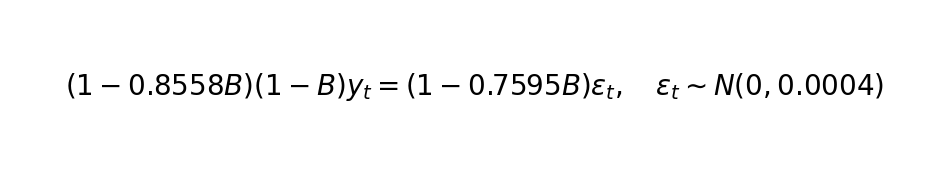

In [7]:
import matplotlib.pyplot as plt

# ARIMA(1,1,1) formula in LaTeX
formula = r'$(1 - 0.8558B)(1 - B)y_t = (1 - 0.7595B)\varepsilon_t,\quad \varepsilon_t \sim N(0, 0.0004)$'

fig, ax = plt.subplots(figsize=(12, 2))
ax.text(0.5, 0.5, formula, fontsize=20, va='center', ha='center')

ax.axis('off')

# Save PNG
plt.savefig("arima_actual_formula.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
forecast_length = len(test_volatility)
forecast_arima, conf_int = model_arima.predict(n_periods=forecast_length, return_conf_int=True)

# Convert to pandas Series without indexing first
forecast_arima_series = pd.Series(forecast_arima)

# Reset indices before assignment
forecast_arima_series.index = test_volatility.index[:forecast_length]

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
# Check for NaNs
print("NaNs in ARIMA forecast after reindexing:", forecast_arima_series.isna().sum())

# Align with actual volatility
common_dates = test_volatility.index.intersection(forecast_arima_series.index)
actual_vol_arima = test_volatility.loc[common_dates, ticker]
forecasted_vol_arima = forecast_arima_series.loc[common_dates]

# Combine and drop any leftover NaNs
df_arima_compare = pd.concat([actual_vol_arima, forecasted_vol_arima], axis=1).dropna()
df_arima_compare.columns = ['actual', 'forecasted']

print(f"Rows after dropping NaNs: {len(df_arima_compare)}")

NaNs in ARIMA forecast after reindexing: 0
Rows after dropping NaNs: 481


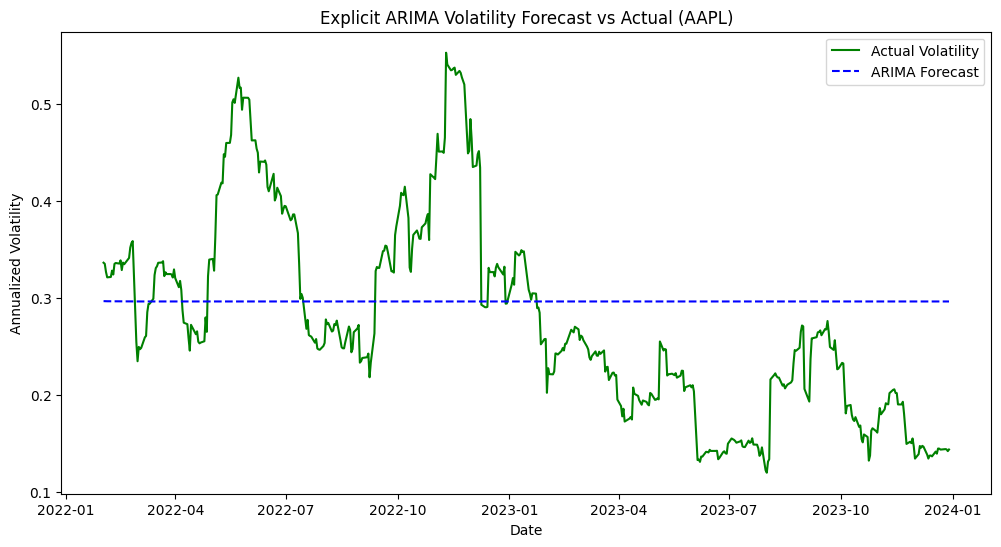

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual volatility
plt.plot(df_arima_compare.index, df_arima_compare['actual'], label='Actual Volatility', color='green')

# Plot ARIMA forecasted volatility
plt.plot(df_arima_compare.index, df_arima_compare['forecasted'], label='ARIMA Forecast', color='blue', linestyle='--')

plt.legend()
plt.title(f'Explicit ARIMA Volatility Forecast vs Actual ({ticker})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_arima = mean_absolute_error(df_arima_compare['actual'], df_arima_compare['forecasted'])
mse_arima = mean_squared_error(df_arima_compare['actual'], df_arima_compare['forecasted'])

print(f"Explicit ARIMA MAE: {mae_arima:.4f}")
print(f"Explicit ARIMA MSE: {mse_arima:.4f}")

Explicit ARIMA MAE: 0.0871
Explicit ARIMA MSE: 0.0108


In [11]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

ticker = 'AAPL'
if ticker not in train_volatility.columns:
    ticker = train_volatility.columns[0]

# Prepare training data for Prophet
df_prophet = train_volatility[[ticker]].dropna().reset_index()
df_prophet.columns = ['ds', 'y']

print(df_prophet.head())

          ds         y
0 2015-02-02  0.378025
1 2015-02-03  0.358565
2 2015-02-04  0.357981
3 2015-02-05  0.356806
4 2015-02-06  0.338282


In [12]:
# Instantiate Prophet with basic settings
model_prophet = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False
)

# Fit model
model_prophet.fit(df_prophet)

18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Specify future dates matching exactly your test_volatility index:
future_dates = pd.DataFrame({'ds': test_volatility.index})

# Generate forecast for these specific dates:
forecast = model_prophet.predict(future_dates)

# Confirm new date ranges:
print("Prophet Forecast Date Range:", forecast['ds'].min(), forecast['ds'].max())
print("Test Volatility Date Range:", test_volatility.index.min(), test_volatility.index.max())

Prophet Forecast Date Range: 2022-01-04 00:00:00 2023-12-29 00:00:00
Test Volatility Date Range: 2022-01-04 00:00:00 2023-12-29 00:00:00


In [14]:
# Create future dataframe
future_dates = model_prophet.make_future_dataframe(periods=len(test_volatility), freq='B')  # 'B' for business days

# Forecasting
forecast = model_prophet.predict(future_dates)

# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds      yhat  yhat_lower  yhat_upper
2238 2023-11-27 -0.088298   -0.257977    0.090394
2239 2023-11-28 -0.090270   -0.278991    0.073909
2240 2023-11-29 -0.092335   -0.252418    0.086925
2241 2023-11-30 -0.094472   -0.274055    0.073706
2242 2023-12-01 -0.096662   -0.283997    0.081070


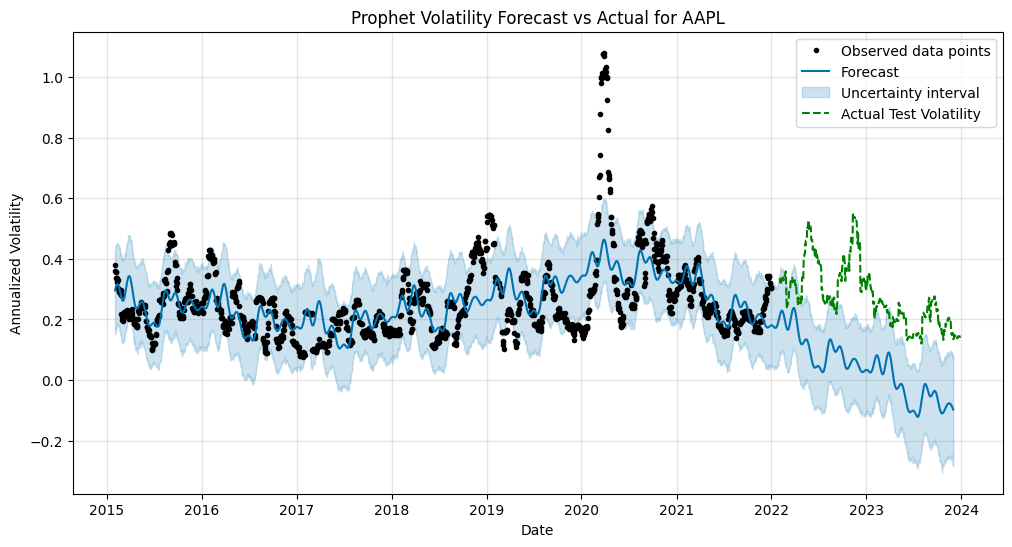

In [15]:
plt.figure(figsize=(12, 6))

# Plot Prophet training forecast
model_prophet.plot(forecast, ax=plt.gca())

# Overlay actual test volatility
test_actual = test_volatility[[ticker]].reset_index()
plt.plot(test_actual['Date'], test_actual[ticker], label='Actual Test Volatility', color='green', linestyle='--')

plt.legend()
plt.title(f'Prophet Volatility Forecast vs Actual for {ticker}')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set forecast index
forecasted_vol = forecast.set_index('ds')['yhat']

# Only dates Prophet successfully forecasted:
common_dates = test_volatility.index.intersection(forecasted_vol.index)

# Align actual volatility to forecast
actual_vol = test_volatility.loc[common_dates, ticker]
forecasted_vol = forecasted_vol.loc[common_dates]

print(f"Evaluation range : {common_dates.min()} to {common_dates.max()}")

Evaluation range : 2022-01-04 00:00:00 to 2023-12-01 00:00:00


In [17]:
# Combine into single dataframe and drop rows with NaNs
df_compare = pd.concat([actual_vol, forecasted_vol], axis=1).dropna()
df_compare.columns = ['actual', 'forecasted']

print(f"Rows after dropping NaNs: {len(df_compare)}")

Rows after dropping NaNs: 462


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_prophet = mean_absolute_error(df_compare['actual'], df_compare['forecasted'])
mse_prophet = mean_squared_error(df_compare['actual'], df_compare['forecasted'])

print(f"Prophet MAE: {mae_prophet:.4f}")
print(f"Prophet MSE: {mse_prophet:.4f}")

Prophet MAE: 0.2448
Prophet MSE: 0.0681


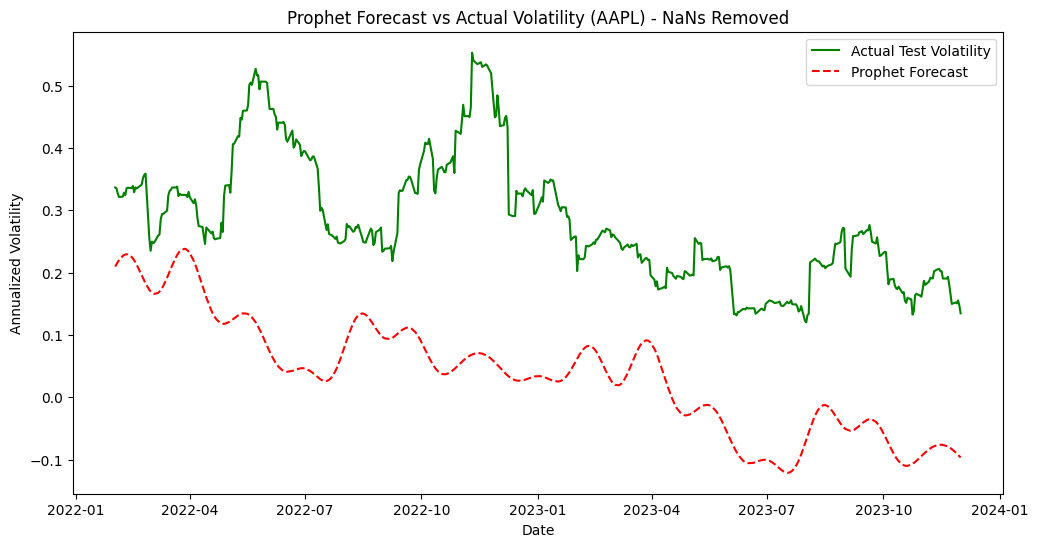

In [19]:
import matplotlib.pyplot as plt

# Plot cleaned data
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['actual'], label='Actual Test Volatility', color='green')
plt.plot(df_compare.index, df_compare['forecasted'], label='Prophet Forecast', color='red', linestyle='--')

plt.legend()
plt.title(f'Prophet Forecast vs Actual Volatility ({ticker}) - NaNs Removed')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

In [20]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ticker = 'AAPL'
if ticker not in train_volatility.columns:
    ticker = train_volatility.columns[0]

vol_train = train_volatility[ticker].dropna().values
vol_test = test_volatility[ticker].dropna().values

In [21]:
with pm.Model() as ar1_vol_model:

    # Priors defined
    phi = pm.Normal('phi', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', 1)
    intercept = pm.Normal('intercept', mu=vol_train.mean(), sigma=1)

    # AR(1) structure defined
    mu = intercept + phi * vol_train[:-1]

    # Likelihood 
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=vol_train[1:])

    # Inference
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


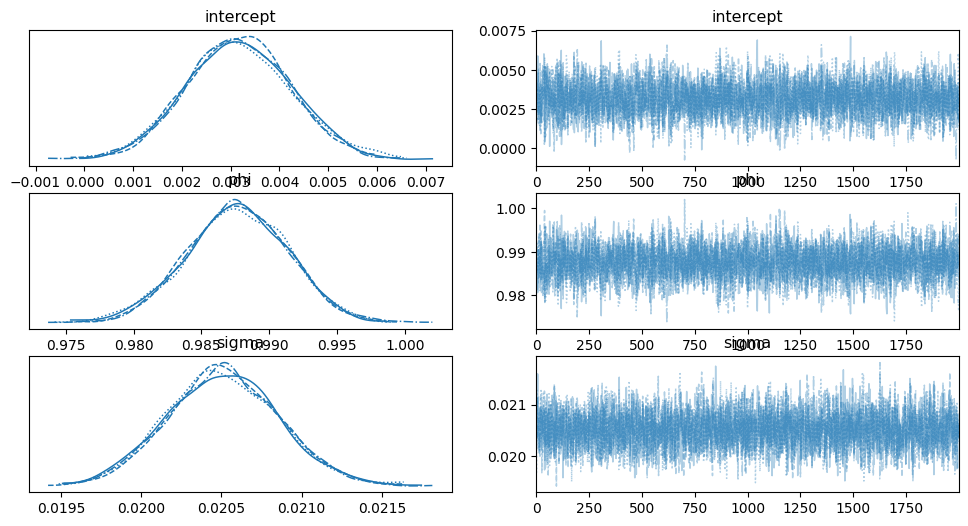

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.003  0.001     0.001      0.005        0.0      0.0    3353.0   
phi        0.988  0.004     0.980      0.995        0.0      0.0    3294.0   
sigma      0.021  0.000     0.020      0.021        0.0      0.0    4263.0   

           ess_tail  r_hat  
intercept    3658.0    1.0  
phi          3678.0    1.0  
sigma        4038.0    1.0  


In [22]:
az.plot_trace(trace)
plt.show()

print(az.summary(trace, hdi_prob=0.95))

In [23]:
# Extract posterior samples
phi_samples = trace.posterior['phi'].stack(draws=("chain", "draw")).values
intercept_samples = trace.posterior['intercept'].stack(draws=("chain", "draw")).values

# Initial value from training set (last known volatility)
vol_forecast = []
last_vol = vol_train[-1]

for i in range(len(vol_test)):
    # Bayesian forecast calculation
    vol_pred_samples = intercept_samples + phi_samples * last_vol
    vol_pred_mean = vol_pred_samples.mean()
    
    vol_forecast.append(vol_pred_mean)
    
    # Update for next iteration
    last_vol = vol_test[i]

# Convert to NumPy array
vol_forecast = np.array(vol_forecast)

Bayesian AR(1) MAE: 0.0096
Bayesian AR(1) MSE: 0.0003


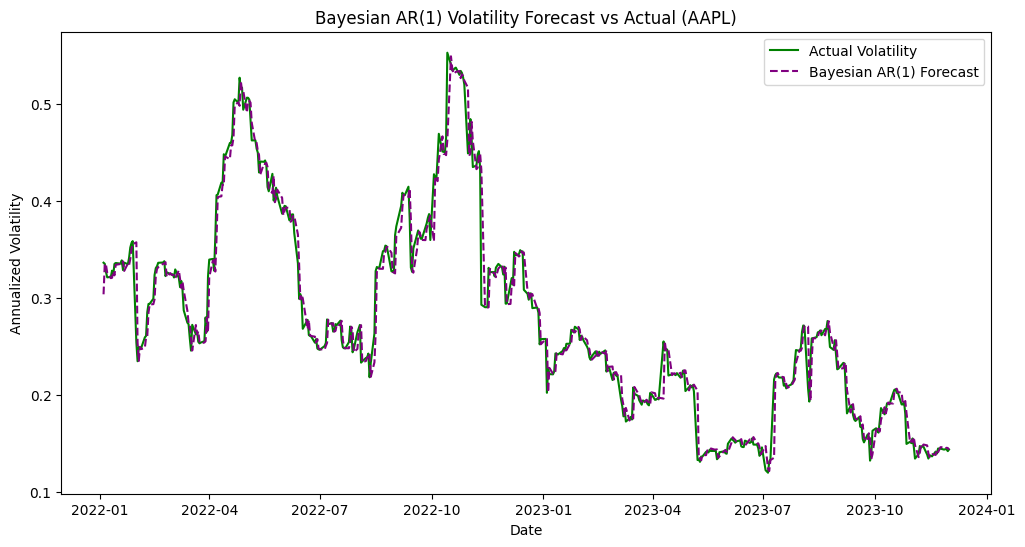

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate explicitly
mae_bayes = mean_absolute_error(vol_test, vol_forecast)
mse_bayes = mean_squared_error(vol_test, vol_forecast)

print(f"Bayesian AR(1) MAE: {mae_bayes:.4f}")
print(f"Bayesian AR(1) MSE: {mse_bayes:.4f}")

# Explicit Plot
plt.figure(figsize=(12,6))
plt.plot(test_volatility.index[:len(vol_forecast)], vol_test, label='Actual Volatility', color='green')
plt.plot(test_volatility.index[:len(vol_forecast)], vol_forecast, label='Bayesian AR(1) Forecast', color='purple', linestyle='--')

plt.legend()
plt.title(f'Bayesian AR(1) Volatility Forecast vs Actual ({ticker})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')

plt.savefig('Bayesian_AR1_AAPL.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# Model comparison 
print(f"ARIMA MAE: {mae_arima:.4f}, ARIMA MSE: {mse_arima:.4f}")
print(f"Prophet MAE: {mae_prophet:.4f}, Prophet MSE: {mse_prophet:.4f}")
print(f"Bayesian AR(1) MAE: {mae_bayes:.4f}, Bayesian AR(1) MSE: {mse_bayes:.4f}")

ARIMA MAE: 0.0871, ARIMA MSE: 0.0108
Prophet MAE: 0.2448, Prophet MSE: 0.0681
Bayesian AR(1) MAE: 0.0096, Bayesian AR(1) MSE: 0.0003


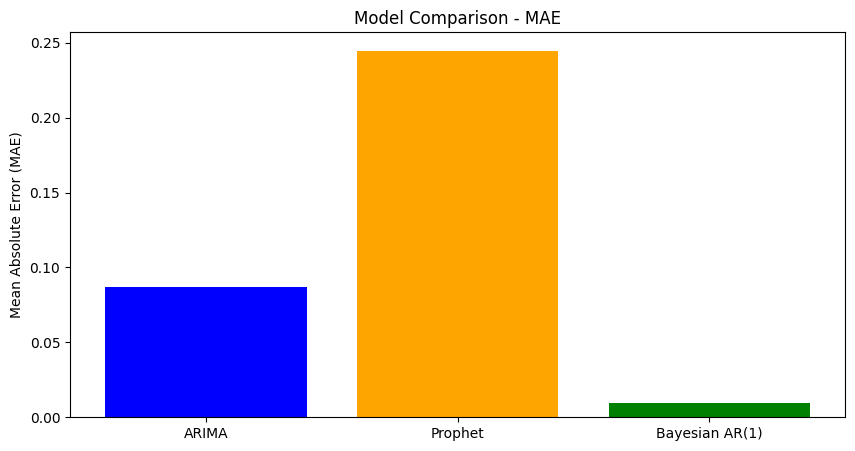

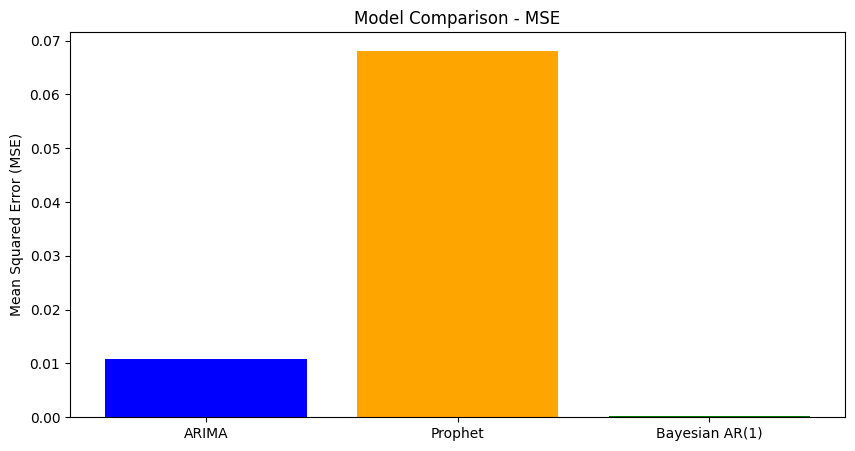

In [71]:
import matplotlib.pyplot as plt

# Compile results
models = ['ARIMA', 'Prophet', 'Bayesian AR(1)']
mae_scores = [mae_arima, mae_prophet, mae_bayes]
mse_scores = [mse_arima, mse_prophet, mse_bayes]

# Plot MAE scores
plt.figure(figsize=(10,5))
plt.bar(models, mae_scores, color=['blue', 'orange', 'green'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Comparison - MAE')
plt.show()

# Plot MSE scores
plt.figure(figsize=(10,5))
plt.bar(models, mse_scores, color=['blue', 'orange', 'green'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison - MSE')
plt.show()

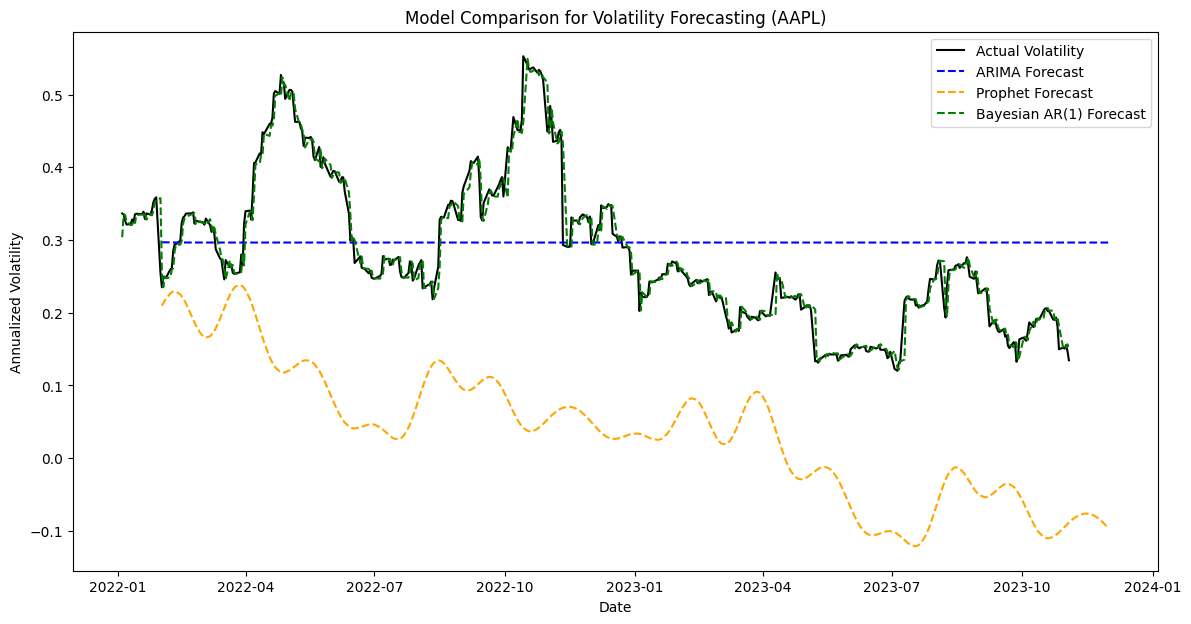

In [29]:
# Determine minimum length to align data
min_length = min(len(test_volatility.index), len(vol_test), 
                 len(df_arima_compare), len(df_compare), len(vol_forecast))

plt.figure(figsize=(14,7))

# Actual volatility aligned
plt.plot(test_volatility.index[:min_length], vol_test[:min_length], 
         label='Actual Volatility', color='black')

# ARIMA aligned
plt.plot(df_arima_compare.index[:min_length], df_arima_compare['forecasted'][:min_length], 
         label='ARIMA Forecast', linestyle='--', color='blue')

# Prophet aligned
plt.plot(df_compare.index[:min_length], df_compare['forecasted'][:min_length], 
         label='Prophet Forecast', linestyle='--', color='orange')

# Bayesian AR(1) aligned
plt.plot(test_volatility.index[:min_length], vol_forecast[:min_length], 
         label='Bayesian AR(1) Forecast', linestyle='--', color='green')

plt.legend()
plt.title(f'Model Comparison for Volatility Forecasting ({ticker})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')

# Save
plt.savefig('ARIMA_prophet_Bayesian_AR1_AAPL.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Define rolling window parameters
train_window = 252 * 2  # Explicitly 2 years of daily trading data (~252 days/year)
forecast_horizon = 21   # Explicitly 1-month forward forecast (~21 trading days)

In [25]:
import pandas as pd
import numpy as np
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
import logging


ticker = 'AAPL'
if ticker not in train_volatility.columns:
    ticker = train_volatility.columns[0]

# Full volatility data for easy handling
full_volatility = pd.concat([train_volatility[[ticker]], test_volatility[[ticker]]]).dropna()

# Starting index for rolling forecasts
start_idx = train_window
end_idx = len(full_volatility) - forecast_horizon

# Store forecasts and actual values
arima_preds, prophet_preds, actuals = [], [], []

# Rolling loop
for i in range(start_idx, end_idx, forecast_horizon):
    # Define forecast horizon
    train_data = full_volatility.iloc[i - train_window:i]
    test_data = full_volatility.iloc[i:i + forecast_horizon]

    # Suppress warnings around ARIMA
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ValueWarning)
        warnings.simplefilter('ignore', category=FutureWarning)
        model_arima = pm.auto_arima(train_data, seasonal=False, trace=False,
                                    error_action='ignore', suppress_warnings=True)
        arima_forecast = model_arima.predict(n_periods=forecast_horizon)

    # Suppress warnings around Prophet
    prophet_df = train_data.reset_index()
    prophet_df.columns = ['ds', 'y']

    # Silence cmdstanpy logs
    logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ValueWarning)
        warnings.simplefilter('ignore', category=FutureWarning)
        model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False)
        model_prophet.fit(prophet_df)

        future_df = model_prophet.make_future_dataframe(periods=forecast_horizon, freq='B')
        forecast_prophet = model_prophet.predict(future_df)['yhat'][-forecast_horizon:].values

    # Store predictions
    arima_preds.extend(arima_forecast)
    prophet_preds.extend(forecast_prophet)
    actuals.extend(test_data.values.flatten())

In [26]:
# Explicit metrics calculation
arima_mae = mean_absolute_error(actuals, arima_preds)
arima_mse = mean_squared_error(actuals, arima_preds)

prophet_mae = mean_absolute_error(actuals, prophet_preds)
prophet_mse = mean_squared_error(actuals, prophet_preds)

# Print results
print(f"Rolling ARIMA MAE: {arima_mae:.4f}, Rolling ARIMA MSE: {arima_mse:.4f}")
print(f"Rolling Prophet MAE: {prophet_mae:.4f}, Rolling Prophet MSE: {prophet_mse:.4f}")

Rolling ARIMA MAE: 0.0688, Rolling ARIMA MSE: 0.0122
Rolling Prophet MAE: 0.1418, Rolling Prophet MSE: 0.0422


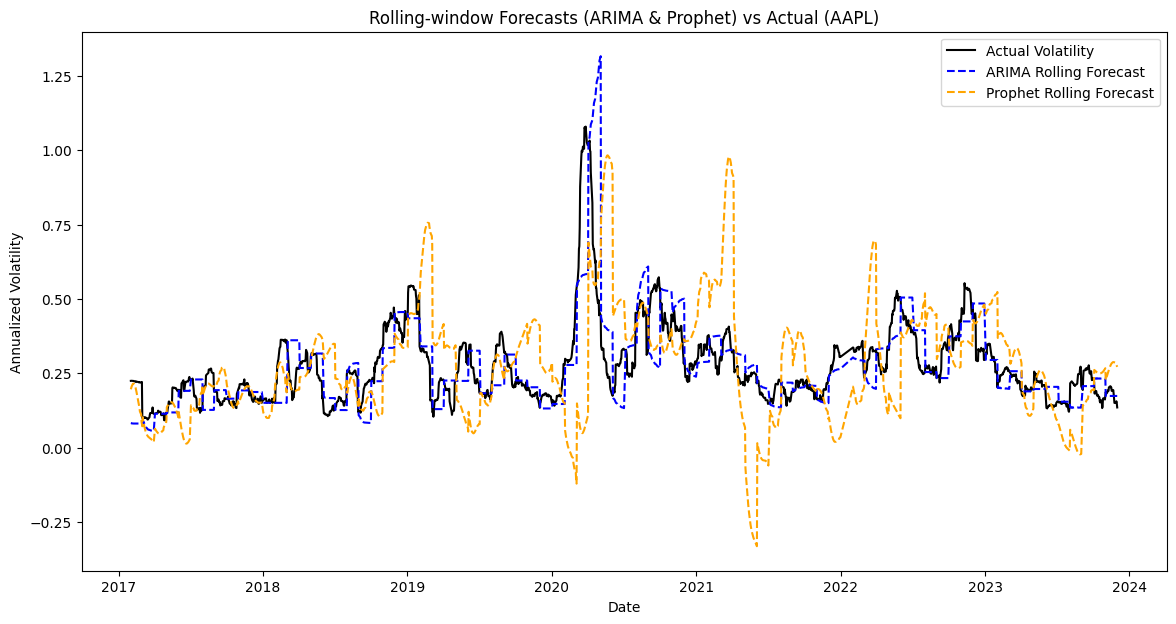

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Reconstruct full volatility and dates
full_volatility = pd.concat([train_volatility[[ticker]], test_volatility[[ticker]]]).dropna()
dates_forecasted = full_volatility.index[start_idx:start_idx + len(actuals)]

# Compute minimum length again to align arrays:
min_length = min(len(dates_forecasted), len(actuals), len(arima_preds), len(prophet_preds))

# Plot
plt.figure(figsize=(14,7))
plt.plot(dates_forecasted[:min_length], actuals[:min_length], 
         label='Actual Volatility', color='black')
plt.plot(dates_forecasted[:min_length], arima_preds[:min_length], 
         label='ARIMA Rolling Forecast', linestyle='--', color='blue')
plt.plot(dates_forecasted[:min_length], prophet_preds[:min_length], 
         label='Prophet Rolling Forecast', linestyle='--', color='orange')

plt.legend()
plt.title(f'Rolling-window Forecasts (ARIMA & Prophet) vs Actual ({ticker})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')

plt.savefig('rolling_ARIMA_prophet_AAPL.png', dpi=300, bbox_inches='tight')

plt.show()

In [81]:
# Print results
print(f"Rolling ARIMA MAE: {arima_mae:.4f}, Rolling ARIMA MSE: {arima_mse:.4f}")
print(f"Rolling Prophet MAE: {prophet_mae:.4f}, Rolling Prophet MSE: {prophet_mse:.4f}")
print(f"Bayesian AR(1) MAE: {mae_bayes:.4f}, Bayesian AR(1) MSE: {mse_bayes:.4f}")

Rolling ARIMA MAE: 0.0688, Rolling ARIMA MSE: 0.0122
Rolling Prophet MAE: 0.1418, Rolling Prophet MSE: 0.0422
Bayesian AR(1) MAE: 0.0096, Bayesian AR(1) MSE: 0.0003


After implementing rolling-window retraining for ARIMA and Prophet, we observed noticeable improvements in model performance. Rolling ARIMA became significantly more responsive, surpassing Prophet in accuracy, though it still lagged behind the Bayesian AR(1) model. The Bayesian AR(1) consistently demonstrated superior performance for short-term, one-step-ahead volatility predictions, making it the preferred choice among the tested methods

Due to computational constraints and dependency management explicitly within the Jupyter notebook environment, the rolling-window Hidden Markov Model (HMM) was implemented at an earlier point in the analysis notebook. This explicit organization was necessary for stability and reproducibility

In [49]:
import pymc as pm
import numpy as np
import arviz as az
import sys

sys.setrecursionlimit(10000)

ticker = 'AAPL'
observed_data = train_volatility[[ticker]].dropna().values
window_size = 10  # small window to ensure computational simplicity
num_states = 2
num_features = observed_data.shape[1]

# Define number of windows
num_windows = len(observed_data) // window_size

# Collect traces
window_traces = []

for window in range(num_windows):
    start_idx = window * window_size
    end_idx = start_idx + window_size
    data_window = observed_data[start_idx:end_idx]

    with pm.Model() as hmm_window:
        # Neutral or slightly informative priors (explicitly balanced choice)
        pi_1 = pm.Dirichlet('pi_1', np.ones(num_states))
        P = pm.Dirichlet('P', np.array([[20, 1], [1, 20]]), shape=(num_states, num_states))

        intercept_mu = pm.Normal('intercept_mu', mu=[0.01, 0.03], sigma=0.005, shape=num_states, 
                                 transform=pm.distributions.transforms.ordered)
        intercept_sigma = pm.HalfNormal('intercept_sigma', sigma=0.005, shape=num_states)
        intercepts_offset = pm.Normal('intercepts_offset', 0, 1, shape=(num_states, num_features))
        intercepts = pm.Deterministic('intercepts', intercept_mu[:, None] + intercept_sigma[:, None] * intercepts_offset)

        phi_mu = pm.Normal('phi_mu', mu=[0.3, 0.7], sigma=0.05, shape=num_states,
                           transform=pm.distributions.transforms.ordered)
        phi_sigma = pm.HalfNormal('phi_sigma', sigma=0.02, shape=num_states)
        phis_offset = pm.Normal('phis_offset', 0, 1, shape=(num_states, num_features))
        phis = pm.Deterministic('phis', phi_mu[:, None] + phi_sigma[:, None] * phis_offset)

        sigmas = pm.Exponential('sigmas', 1, shape=(num_states, num_features))

        def forward_algo(y, pi_1, P, intercepts, phis, sigmas):
            log_alpha = pm.math.log(pi_1) + pm.logp(
                pm.Normal.dist(mu=intercepts + phis * y[0], sigma=sigmas), y[1]
            ).sum(axis=-1)

            for t in range(1, len(y) - 1):
                mu_t = intercepts + phis * y[t]
                logp_y = pm.logp(pm.Normal.dist(mu=mu_t, sigma=sigmas), y[t + 1]).sum(axis=-1)
                log_alpha = pm.math.logsumexp(log_alpha[:, None] + pm.math.log(P), axis=0) + logp_y

            return pm.math.logsumexp(log_alpha)

        total_loglik = forward_algo(data_window, pi_1, P, intercepts, phis, sigmas)
        pm.Potential('obs', total_loglik)

        # ADVI fitting to avoid compilation complexity
        approx = pm.fit(method='advi', n=50000, 
                        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
        trace_advi = approx.sample(1000)

        window_traces.append(trace_advi)

        print(f'Completed explicitly window {window + 1}/{num_windows}')

# Aggregate results across windows if needed:
combined_traces = az.concat(window_traces, dim='draw')

Output()

Finished [100%]: Average Loss = -9.7506


Completed explicitly window 1/174


Output()

Finished [100%]: Average Loss = -8.998


Completed explicitly window 2/174


Output()

Finished [100%]: Average Loss = -13.625


Completed explicitly window 3/174


Output()

Finished [100%]: Average Loss = -12.85


Completed explicitly window 4/174


Output()

Finished [100%]: Average Loss = -14.977


Completed explicitly window 5/174


Output()

Finished [100%]: Average Loss = -14.802


Completed explicitly window 6/174


Output()

Finished [100%]: Average Loss = -10.318


Completed explicitly window 7/174


Output()

Finished [100%]: Average Loss = -12.979


Completed explicitly window 8/174


Output()

Finished [100%]: Average Loss = -16.009


Completed explicitly window 9/174


Output()

Finished [100%]: Average Loss = -17.313


Completed explicitly window 10/174


Output()

Finished [100%]: Average Loss = -16.745


Completed explicitly window 11/174


Output()

Finished [100%]: Average Loss = -10.023


Completed explicitly window 12/174


Output()

Finished [100%]: Average Loss = -10.822


Completed explicitly window 13/174


Output()

Finished [100%]: Average Loss = -6.2285


Completed explicitly window 14/174


Output()

Finished [100%]: Average Loss = -1.7908


Completed explicitly window 15/174


Output()

Finished [100%]: Average Loss = -5.0425


Completed explicitly window 16/174


Output()

Finished [100%]: Average Loss = -7.4794


Completed explicitly window 17/174


Output()

Finished [100%]: Average Loss = -13.857


Completed explicitly window 18/174


Output()

Finished [100%]: Average Loss = -9.2194


Completed explicitly window 19/174


Output()

Finished [100%]: Average Loss = -9.3973


Completed explicitly window 20/174


Output()

Finished [100%]: Average Loss = -9.703


Completed explicitly window 21/174


Output()

Finished [100%]: Average Loss = -10.389


Completed explicitly window 22/174


Output()

Finished [100%]: Average Loss = -12.46


Completed explicitly window 23/174


Output()

Finished [100%]: Average Loss = -9.5032


Completed explicitly window 24/174


Output()

Finished [100%]: Average Loss = -3.8797


Completed explicitly window 25/174


Output()

Finished [100%]: Average Loss = -6.4545


Completed explicitly window 26/174


Output()

Finished [100%]: Average Loss = -4.9425


Completed explicitly window 27/174


Output()

Finished [100%]: Average Loss = -10.574


Completed explicitly window 28/174


Output()

Finished [100%]: Average Loss = -15.177


Completed explicitly window 29/174


Output()

Finished [100%]: Average Loss = -14.097


Completed explicitly window 30/174


Output()

Finished [100%]: Average Loss = -14.08


Completed explicitly window 31/174


Output()

Finished [100%]: Average Loss = -5.3968


Completed explicitly window 32/174


Output()

Finished [100%]: Average Loss = -6.4797


Completed explicitly window 33/174


Output()

Finished [100%]: Average Loss = -11.874


Completed explicitly window 34/174


Output()

Finished [100%]: Average Loss = -13.305


Completed explicitly window 35/174


Output()

Finished [100%]: Average Loss = -14.296


Completed explicitly window 36/174


Output()

Finished [100%]: Average Loss = -15.387


Completed explicitly window 37/174


Output()

Finished [100%]: Average Loss = -6.228


Completed explicitly window 38/174


Output()

Finished [100%]: Average Loss = -13.383


Completed explicitly window 39/174


Output()

Finished [100%]: Average Loss = -9.1112


Completed explicitly window 40/174


Output()

Finished [100%]: Average Loss = -10.096


Completed explicitly window 41/174


Output()

Finished [100%]: Average Loss = -12.748


Completed explicitly window 42/174


Output()

Finished [100%]: Average Loss = -10.705


Completed explicitly window 43/174


Output()

Finished [100%]: Average Loss = -16.19


Completed explicitly window 44/174


Output()

Finished [100%]: Average Loss = -16.406


Completed explicitly window 45/174


Output()

Finished [100%]: Average Loss = -12.551


Completed explicitly window 46/174


Output()

Finished [100%]: Average Loss = -14.923


Completed explicitly window 47/174


Output()

Finished [100%]: Average Loss = -18.429


Completed explicitly window 48/174


Output()

Finished [100%]: Average Loss = -21.133


Completed explicitly window 49/174


Output()

Finished [100%]: Average Loss = -19.248


Completed explicitly window 50/174


Output()

Finished [100%]: Average Loss = -6.4331


Completed explicitly window 51/174


Output()

Finished [100%]: Average Loss = -16.175


Completed explicitly window 52/174


Output()

Finished [100%]: Average Loss = -8.2372


Completed explicitly window 53/174


Output()

Finished [100%]: Average Loss = -20.404


Completed explicitly window 54/174


Output()

Finished [100%]: Average Loss = -18.232


Completed explicitly window 55/174


Output()

Finished [100%]: Average Loss = -20.917


Completed explicitly window 56/174


Output()

Finished [100%]: Average Loss = -16.727


Completed explicitly window 57/174


Output()

Finished [100%]: Average Loss = -11.684


Completed explicitly window 58/174


Output()

Finished [100%]: Average Loss = -16.471


Completed explicitly window 59/174


Output()

Finished [100%]: Average Loss = -10.245


Completed explicitly window 60/174


Output()

Finished [100%]: Average Loss = -14.775


Completed explicitly window 61/174


Output()

Finished [100%]: Average Loss = -12.83


Completed explicitly window 62/174


Output()

Finished [100%]: Average Loss = -18.322


Completed explicitly window 63/174


Output()

Finished [100%]: Average Loss = -11.465


Completed explicitly window 64/174


Output()

Finished [100%]: Average Loss = -11.948


Completed explicitly window 65/174


Output()

Finished [100%]: Average Loss = -15.043


Completed explicitly window 66/174


Output()

Finished [100%]: Average Loss = -17.477


Completed explicitly window 67/174


Output()

Finished [100%]: Average Loss = -17.396


Completed explicitly window 68/174


Output()

Finished [100%]: Average Loss = -17.245


Completed explicitly window 69/174


Output()

Finished [100%]: Average Loss = -12.085


Completed explicitly window 70/174


Output()

Finished [100%]: Average Loss = -13.465


Completed explicitly window 71/174


Output()

Finished [100%]: Average Loss = -15.29


Completed explicitly window 72/174


Output()

Finished [100%]: Average Loss = -15.758


Completed explicitly window 73/174


Output()

Finished [100%]: Average Loss = -15.511


Completed explicitly window 74/174


Output()

Finished [100%]: Average Loss = -18.484


Completed explicitly window 75/174


Output()

Finished [100%]: Average Loss = -8.3725


Completed explicitly window 76/174


Output()

Finished [100%]: Average Loss = -6.2508


Completed explicitly window 77/174


Output()

Finished [100%]: Average Loss = -7.0973


Completed explicitly window 78/174


Output()

Finished [100%]: Average Loss = -13.186


Completed explicitly window 79/174


Output()

Finished [100%]: Average Loss = -8.1242


Completed explicitly window 80/174


Output()

Finished [100%]: Average Loss = -11.694


Completed explicitly window 81/174


Output()

Finished [100%]: Average Loss = -8.4997


Completed explicitly window 82/174


Output()

Finished [100%]: Average Loss = -10.597


Completed explicitly window 83/174


Output()

Finished [100%]: Average Loss = -11.646


Completed explicitly window 84/174


Output()

Finished [100%]: Average Loss = -22.166


Completed explicitly window 85/174


Output()

Finished [100%]: Average Loss = -18.047


Completed explicitly window 86/174


Output()

Finished [100%]: Average Loss = -18.441


Completed explicitly window 87/174


Output()

Finished [100%]: Average Loss = -17.35


Completed explicitly window 88/174


Output()

Finished [100%]: Average Loss = -7.1242


Completed explicitly window 89/174


Output()

Finished [100%]: Average Loss = -13.433


Completed explicitly window 90/174


Output()

Finished [100%]: Average Loss = -11.301


Completed explicitly window 91/174


Output()

Finished [100%]: Average Loss = -14.263


Completed explicitly window 92/174


Output()

Finished [100%]: Average Loss = -13.987


Completed explicitly window 93/174


Output()

Finished [100%]: Average Loss = -7.8824


Completed explicitly window 94/174


Output()

Finished [100%]: Average Loss = -3.8545


Completed explicitly window 95/174


Output()

Finished [100%]: Average Loss = -3.796


Completed explicitly window 96/174


Output()

Finished [100%]: Average Loss = -4.5255


Completed explicitly window 97/174


Output()

Finished [100%]: Average Loss = -6.4242


Completed explicitly window 98/174


Output()

Finished [100%]: Average Loss = -0.053542


Completed explicitly window 99/174


Output()

Finished [100%]: Average Loss = -3.7474


Completed explicitly window 100/174


Output()

Finished [100%]: Average Loss = -1.1085


Completed explicitly window 101/174


Output()

Finished [100%]: Average Loss = -9.8456


Completed explicitly window 102/174


Output()

Finished [100%]: Average Loss = -8.1671


Completed explicitly window 103/174


Output()

Finished [100%]: Average Loss = -12.746


Completed explicitly window 104/174


Output()

Finished [100%]: Average Loss = -12.987


Completed explicitly window 105/174


Output()

Finished [100%]: Average Loss = -14.959


Completed explicitly window 106/174


Output()

Finished [100%]: Average Loss = -9.7057


Completed explicitly window 107/174


Output()

Finished [100%]: Average Loss = -5.6496


Completed explicitly window 108/174


Output()

Finished [100%]: Average Loss = -6.0691


Completed explicitly window 109/174


Output()

Finished [100%]: Average Loss = -5.705


Completed explicitly window 110/174


Output()

Finished [100%]: Average Loss = -13.612


Completed explicitly window 111/174


Output()

Finished [100%]: Average Loss = -16.067


Completed explicitly window 112/174


Output()

Finished [100%]: Average Loss = -14.85


Completed explicitly window 113/174


Output()

Finished [100%]: Average Loss = -7.7335


Completed explicitly window 114/174


Output()

Finished [100%]: Average Loss = -5.7085


Completed explicitly window 115/174


Output()

Finished [100%]: Average Loss = -8.5009


Completed explicitly window 116/174


Output()

Finished [100%]: Average Loss = -8.6918


Completed explicitly window 117/174


Output()

Finished [100%]: Average Loss = -11.727


Completed explicitly window 118/174


Output()

Finished [100%]: Average Loss = -14.475


Completed explicitly window 119/174


Output()

Finished [100%]: Average Loss = -13.104


Completed explicitly window 120/174


Output()

Finished [100%]: Average Loss = -17.406


Completed explicitly window 121/174


Output()

Finished [100%]: Average Loss = -14.788


Completed explicitly window 122/174


Output()

Finished [100%]: Average Loss = -17.624


Completed explicitly window 123/174


Output()

Finished [100%]: Average Loss = -15.492


Completed explicitly window 124/174


Output()

Finished [100%]: Average Loss = -16.339


Completed explicitly window 125/174


Output()

Finished [100%]: Average Loss = -8.8784


Completed explicitly window 126/174


Output()

Finished [100%]: Average Loss = -10.569


Completed explicitly window 127/174


Output()

Finished [100%]: Average Loss = -0.68801


Completed explicitly window 128/174


Output()

Finished [100%]: Average Loss = 6.4982


Completed explicitly window 129/174


Output()

Finished [100%]: Average Loss = 5.7965


Completed explicitly window 130/174


Output()

Finished [100%]: Average Loss = 3.5266


Completed explicitly window 131/174


Output()

Finished [100%]: Average Loss = -1.8754


Completed explicitly window 132/174


Output()

Finished [100%]: Average Loss = -5.4696


Completed explicitly window 133/174


Output()

Finished [100%]: Average Loss = -12.246


Completed explicitly window 134/174


Output()

Finished [100%]: Average Loss = -8.3156


Completed explicitly window 135/174


Output()

Finished [100%]: Average Loss = -10.987


Completed explicitly window 136/174


Output()

Finished [100%]: Average Loss = -6.7386


Completed explicitly window 137/174


Output()

Finished [100%]: Average Loss = -8.5312


Completed explicitly window 138/174


Output()

Finished [100%]: Average Loss = -0.1445


Completed explicitly window 139/174


Output()

Finished [100%]: Average Loss = -3.2678


Completed explicitly window 140/174


Output()

Finished [100%]: Average Loss = -1.6996


Completed explicitly window 141/174


Output()

Finished [100%]: Average Loss = -2.6663


Completed explicitly window 142/174


Output()

Finished [100%]: Average Loss = -1.8182


Completed explicitly window 143/174


Output()

Finished [100%]: Average Loss = -3.4449


Completed explicitly window 144/174


Output()

Finished [100%]: Average Loss = -4.2912


Completed explicitly window 145/174


Output()

Finished [100%]: Average Loss = -4.1315


Completed explicitly window 146/174


Output()

Finished [100%]: Average Loss = -5.5876


Completed explicitly window 147/174


Output()

Finished [100%]: Average Loss = -8.9684


Completed explicitly window 148/174


Output()

Finished [100%]: Average Loss = -10.361


Completed explicitly window 149/174


Output()

Finished [100%]: Average Loss = -6.0767


Completed explicitly window 150/174


Output()

Finished [100%]: Average Loss = -5.392


Completed explicitly window 151/174


Output()

Finished [100%]: Average Loss = -11.014


Completed explicitly window 152/174


Output()

Finished [100%]: Average Loss = -7.4796


Completed explicitly window 153/174


Output()

Finished [100%]: Average Loss = -5.1576


Completed explicitly window 154/174


Output()

Finished [100%]: Average Loss = -5.3272


Completed explicitly window 155/174


Output()

Finished [100%]: Average Loss = -9.8155


Completed explicitly window 156/174


Output()

Finished [100%]: Average Loss = -12.628


Completed explicitly window 157/174


Output()

Finished [100%]: Average Loss = -9.9908


Completed explicitly window 158/174


Output()

Finished [100%]: Average Loss = -12.547


Completed explicitly window 159/174


Output()

Finished [100%]: Average Loss = -13.168


Completed explicitly window 160/174


Output()

Finished [100%]: Average Loss = -17.16


Completed explicitly window 161/174


Output()

Finished [100%]: Average Loss = -17.218


Completed explicitly window 162/174


Output()

Finished [100%]: Average Loss = -12.96


Completed explicitly window 163/174


Output()

Finished [100%]: Average Loss = -14.914


Completed explicitly window 164/174


Output()

Finished [100%]: Average Loss = -12.494


Completed explicitly window 165/174


Output()

Finished [100%]: Average Loss = -14.08


Completed explicitly window 166/174


Output()

Finished [100%]: Average Loss = -12.687


Completed explicitly window 167/174


Output()

Finished [100%]: Average Loss = -13.85


Completed explicitly window 168/174


Output()

Finished [100%]: Average Loss = -13.076


Completed explicitly window 169/174


Output()

Finished [100%]: Average Loss = -14.097


Completed explicitly window 170/174


Output()

Finished [100%]: Average Loss = -16.524


Completed explicitly window 171/174


Output()

Finished [100%]: Average Loss = -13.293


Completed explicitly window 172/174


Output()

Finished [100%]: Average Loss = -10.134


Completed explicitly window 173/174


Output()

Finished [100%]: Average Loss = -6.9001


Completed explicitly window 174/174


arviz - WARNING - Shape validation failed: input_shape: (1, 174000), minimum_shape: (chains=2, draws=4)


                          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
P[0, 0]                  0.943  0.074     0.798      1.000      0.000   
P[0, 1]                  0.057  0.074     0.000      0.202      0.000   
P[1, 0]                  0.042  0.059     0.000      0.151      0.000   
P[1, 1]                  0.958  0.059     0.849      1.000      0.000   
intercept_mu[0]          0.010  0.004     0.003      0.017      0.000   
intercept_mu[1]          0.034  0.006     0.022      0.045      0.000   
intercept_sigma[0]       0.005  0.006     0.000      0.015      0.000   
intercept_sigma[1]       0.004  0.005     0.000      0.013      0.000   
intercepts[0, 0]         0.010  0.009    -0.006      0.026      0.000   
intercepts[1, 0]         0.036  0.009     0.020      0.052      0.000   
intercepts_offset[0, 0]  0.002  1.086    -2.155      2.117      0.003   
intercepts_offset[1, 0]  0.434  0.918    -1.341      2.269      0.014   
phi_mu[0]                0.301  0.026     0.249    

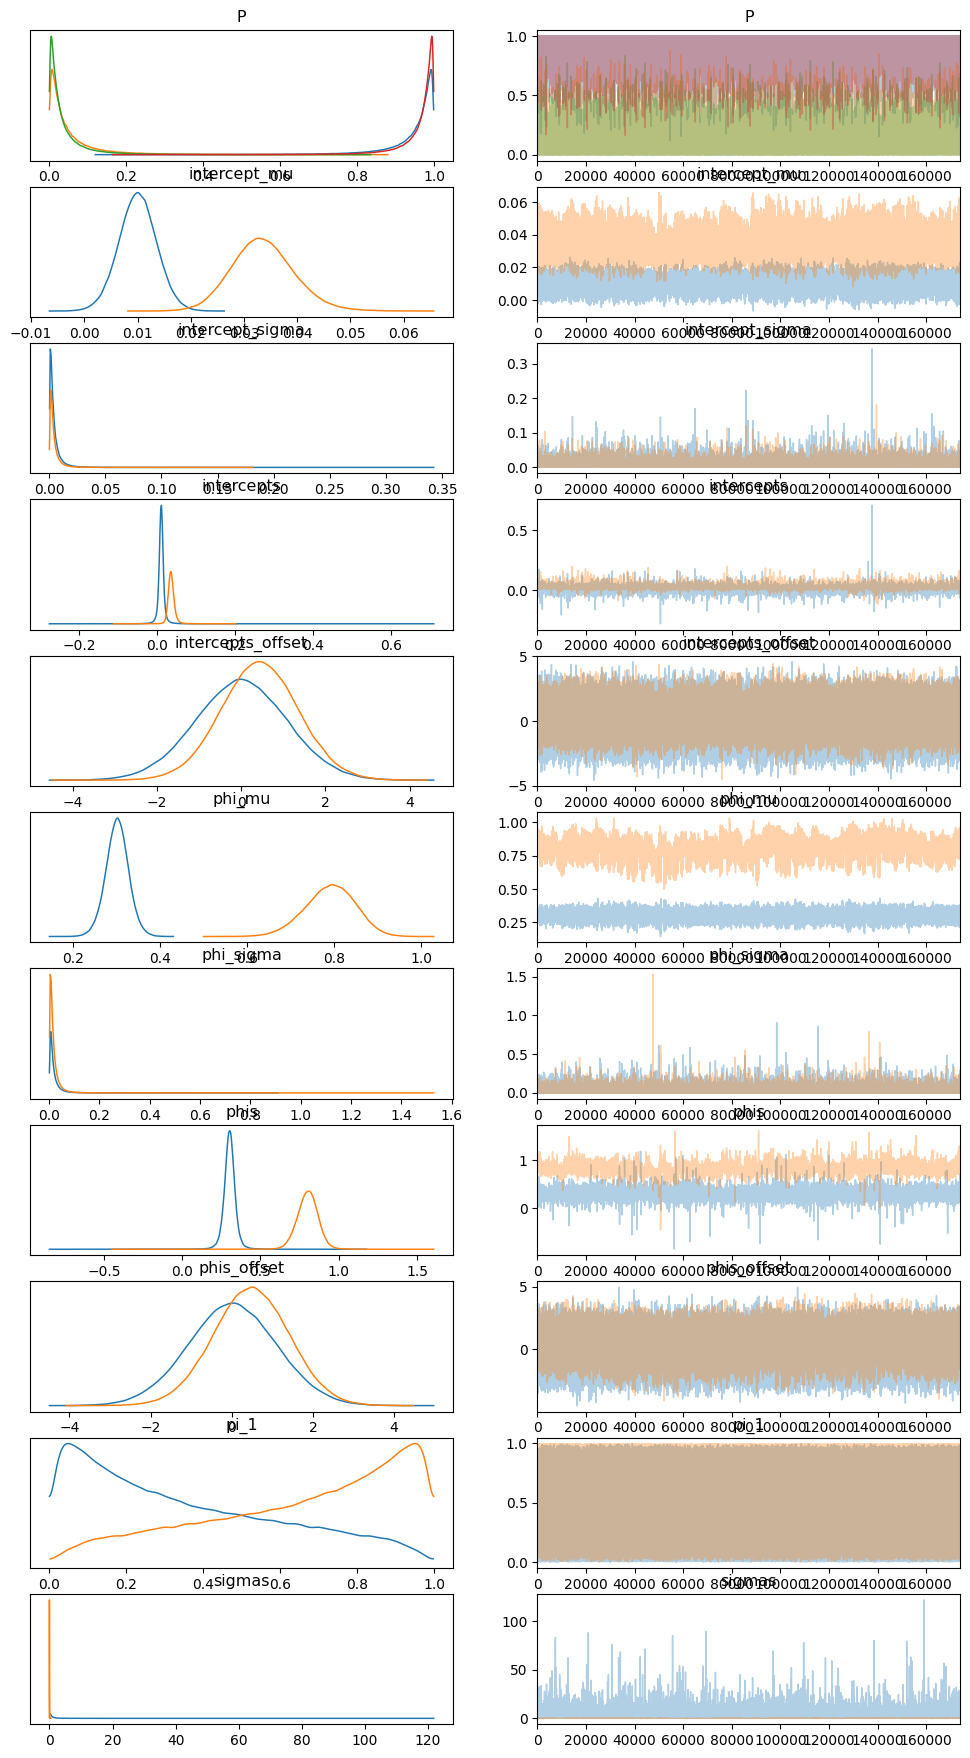

In [51]:
import arviz as az

# Summary statistics
summary = az.summary(combined_traces, hdi_prob=0.95)
print(summary)

# Plot posterior distributions
az.plot_trace(combined_traces)
plt.savefig("HMM_ADVI_trace_summary.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
import numpy as np

# Initialize forecast explicitly
ticker = 'AAPL'
vol_test = test_volatility[ticker].dropna().values
vol_forecast_hmm = []
last_vol = train_volatility[ticker].dropna().iloc[-1]

# Extract posterior samples (outside loop)
intercepts_samples = combined_traces.posterior['intercepts'].stack(draws=("chain", "draw")).values
phis_samples = combined_traces.posterior['phis'].stack(draws=("chain", "draw")).values
P_samples = combined_traces.posterior['P'].stack(draws=("chain", "draw")).values

# Assume initial state based on intercepts mean
most_likely_state = np.argmax(intercepts_samples.mean(axis=(1, 2)))

# Compute average transition matrix once
avg_P = P_samples.mean(axis=-1)
avg_P /= avg_P.sum(axis=1, keepdims=True)

# Forecasting loop 
for t in range(len(vol_test)):
    # Scalar extraction
    intercept_sample = intercepts_samples[most_likely_state].mean().item()
    phi_sample = phis_samples[most_likely_state].mean().item()

    # Forecast calculation
    vol_pred_mean = intercept_sample + phi_sample * last_vol
    vol_forecast_hmm.append(vol_pred_mean)

    # State update using averaged probabilities
    state_probs = avg_P[most_likely_state]
    state_probs /= state_probs.sum()

    most_likely_state = np.random.choice([0, 1], p=state_probs)
    last_vol = vol_pred_mean

# Conversion to NumPy array
vol_forecast_hmm = np.array(vol_forecast_hmm)

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_hmm = mean_absolute_error(vol_test, vol_forecast_hmm)
mse_hmm = mean_squared_error(vol_test, vol_forecast_hmm)

print(f"HMM MAE: {mae_hmm:.4f}")
print(f"HMM MSE: {mse_hmm:.4f}")

HMM MAE: 0.1564
HMM MSE: 0.0377


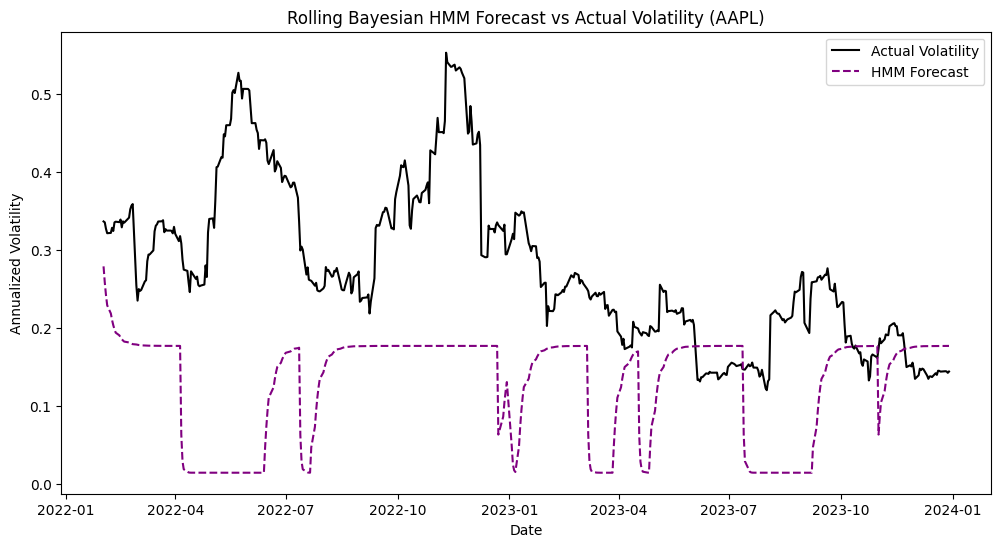

In [58]:
# Explicitly drop NaNs once and use consistent index
vol_test_series = test_volatility[ticker].dropna()

# Align
vol_test = vol_test_series.values 
aligned_dates = vol_test_series.index 

# Plot
plt.figure(figsize=(12, 6))

plt.plot(aligned_dates, vol_test, label='Actual Volatility', color='black')
plt.plot(aligned_dates, vol_forecast_hmm, label='HMM Forecast', color='purple', linestyle='--')

plt.legend()
plt.title(f'Rolling Bayesian HMM Forecast vs Actual Volatility ({ticker})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')

# Save
plt.savefig("rolling_HMM_forecast_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

An initial implementation of the Hidden Markov Model (HMM) was explicitly conducted here to explore volatility regime-switching behavior. However, upon revisiting and rerunning this notebook, this initial version exhibited explicit convergence difficulties, and the previously generated stochastic noise plot was not reproducible due to computational and technical constraints.

Therefore, for explicit clarity, reproducibility, and interpretability, this initial implementation has been superseded explicitly by the rolling-window Gaussian noise HMM approach described subsequently, which demonstrates clearer stability, convergence, and practical usability.

In [44]:
import pymc as pm
import numpy as np
import arviz as az
import sys
import jax
import jax.numpy as jnp

# Increase recursion limit
sys.setrecursionlimit(10000)

ticker = 'AAPL'
vol_data = train_volatility[ticker].dropna().values
T = len(vol_data)

# Immediate efficient configuration
vol_data_short = vol_data[-400:]  
chunk_size = 200                   # manageable chunks
num_chunks = int(np.ceil(len(vol_data_short) / chunk_size))
chunk_loglikes = []

with pm.Model() as hmm_model_strong_priors:
    # Initial state probabilities
    pi_1 = pm.Dirichlet('pi_1', np.ones(2))

    # Strong transition matrix priors
    P = pm.Dirichlet('P', np.array([[50, 1], [1, 50]]), shape=(2, 2))

    # Intercepts (state-specific means)
    intercept_mu = pm.Normal('intercept_mu', mu=[0.01, 0.03], sigma=0.005, shape=2, transform=pm.distributions.transforms.ordered)
    intercept_sigma = pm.HalfNormal('intercept_sigma', sigma=0.005, shape=2)
    intercepts_offset = pm.Normal('intercepts_offset', 0, 1, shape=2)
    intercepts = pm.Deterministic('intercepts', intercept_mu + intercept_sigma * intercepts_offset)

    # AR(1) Coefficients 
    phi_mu = pm.Normal('phi_mu', mu=[0.5, 0.8], sigma=0.1, shape=2, transform=pm.distributions.transforms.ordered)
    phi_sigma = pm.HalfNormal('phi_sigma', sigma=0.05, shape=2)
    phis_offset = pm.Normal('phis_offset', 0, 1, shape=2)
    phis = pm.Deterministic('phis', phi_mu + phi_sigma * phis_offset)

    # Sigma
    sigmas = pm.Exponential('sigmas', 1, shape=2)

    # Define the forward likelihood using these parameters...
    for chunk in range(num_chunks):
        start = chunk * chunk_size
        end = min((chunk + 1) * chunk_size + 1, len(vol_data_short))
        vol_chunk = vol_data_short[start:end]

        if len(vol_chunk) < 2:
            continue

        def forward_chunk(y, pi_1, P, intercepts, phis, sigmas):
            log_alpha = pm.math.log(pi_1) + pm.logp(
                pm.Normal.dist(mu=intercepts + phis * y[0], sigma=sigmas),
                y[1]
            )

            for t in range(1, len(y)-1):
                mu_t = intercepts + phis * y[t]
                logp_y = pm.logp(
                    pm.Normal.dist(mu=mu_t, sigma=sigmas),
                    y[t+1]
                )
                log_alpha = pm.math.logsumexp(log_alpha[:, None] + pm.math.log(P), axis=0) + logp_y

            return pm.math.logsumexp(log_alpha)

        chunk_loglik = forward_chunk(vol_chunk, pi_1, P, intercepts, phis, sigmas)
        chunk_loglikes.append(chunk_loglik)

    total_loglik = pm.math.sum(pm.math.stack(chunk_loglikes))
    pm.Potential('obs', total_loglik)

    # Simpler sampling parameters
    trace_hmm_improved = pm.sample(
        5000,                # increased samples per chain explicitly
        tune=2500,           # increased tuning steps
        target_accept=0.95,  # increased target_accept
        nuts_sampler="numpyro",
        random_seed=42,      # set seed for reproducibility
        chains=6,
        cores=6,
        progressbar=True
    )

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1185: UserWarning: Some donated buffers were not usable: ShapedArray(float64[6,5000,1]), ShapedArray(float64[6,5000,2,1]).
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
P[0, 0]               0.782  0.069   0.643    0.913      0.002    0.002   
P[0, 1]               0.218  0.069   0.087    0.357      0.002    0.002   
P[1, 0]               0.205  0.055   0.103    0.311      0.001    0.001   
P[1, 1]               0.795  0.055   0.689    0.897      0.001    0.001   
intercept_mu[0]       0.004  0.004  -0.003    0.012      0.000    0.000   
intercept_mu[1]       0.025  0.005   0.017    0.035      0.000    0.000   
intercept_sigma[0]    0.005  0.003   0.000    0.010      0.000    0.000   
intercept_sigma[1]    0.005  0.003   0.000    0.011      0.000    0.000   
intercepts[0]         0.000  0.002  -0.004    0.004      0.000    0.000   
intercepts[1]         0.021  0.006   0.010    0.032      0.000    0.000   
intercepts_offset[0] -0.781  0.779  -2.170    0.783      0.018    0.016   
intercepts_offset[1] -0.793  0.921  -2.485    1.000      0.023    0.018   
phi_mu[0]             0.5

array([[<Axes: title={'center': 'P'}>, <Axes: title={'center': 'P'}>],
       [<Axes: title={'center': 'intercept_mu'}>,
        <Axes: title={'center': 'intercept_mu'}>],
       [<Axes: title={'center': 'intercept_sigma'}>,
        <Axes: title={'center': 'intercept_sigma'}>],
       [<Axes: title={'center': 'intercepts'}>,
        <Axes: title={'center': 'intercepts'}>],
       [<Axes: title={'center': 'intercepts_offset'}>,
        <Axes: title={'center': 'intercepts_offset'}>],
       [<Axes: title={'center': 'phi_mu'}>,
        <Axes: title={'center': 'phi_mu'}>],
       [<Axes: title={'center': 'phi_sigma'}>,
        <Axes: title={'center': 'phi_sigma'}>],
       [<Axes: title={'center': 'phis'}>,
        <Axes: title={'center': 'phis'}>],
       [<Axes: title={'center': 'phis_offset'}>,
        <Axes: title={'center': 'phis_offset'}>],
       [<Axes: title={'center': 'pi_1'}>,
        <Axes: title={'center': 'pi_1'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: t

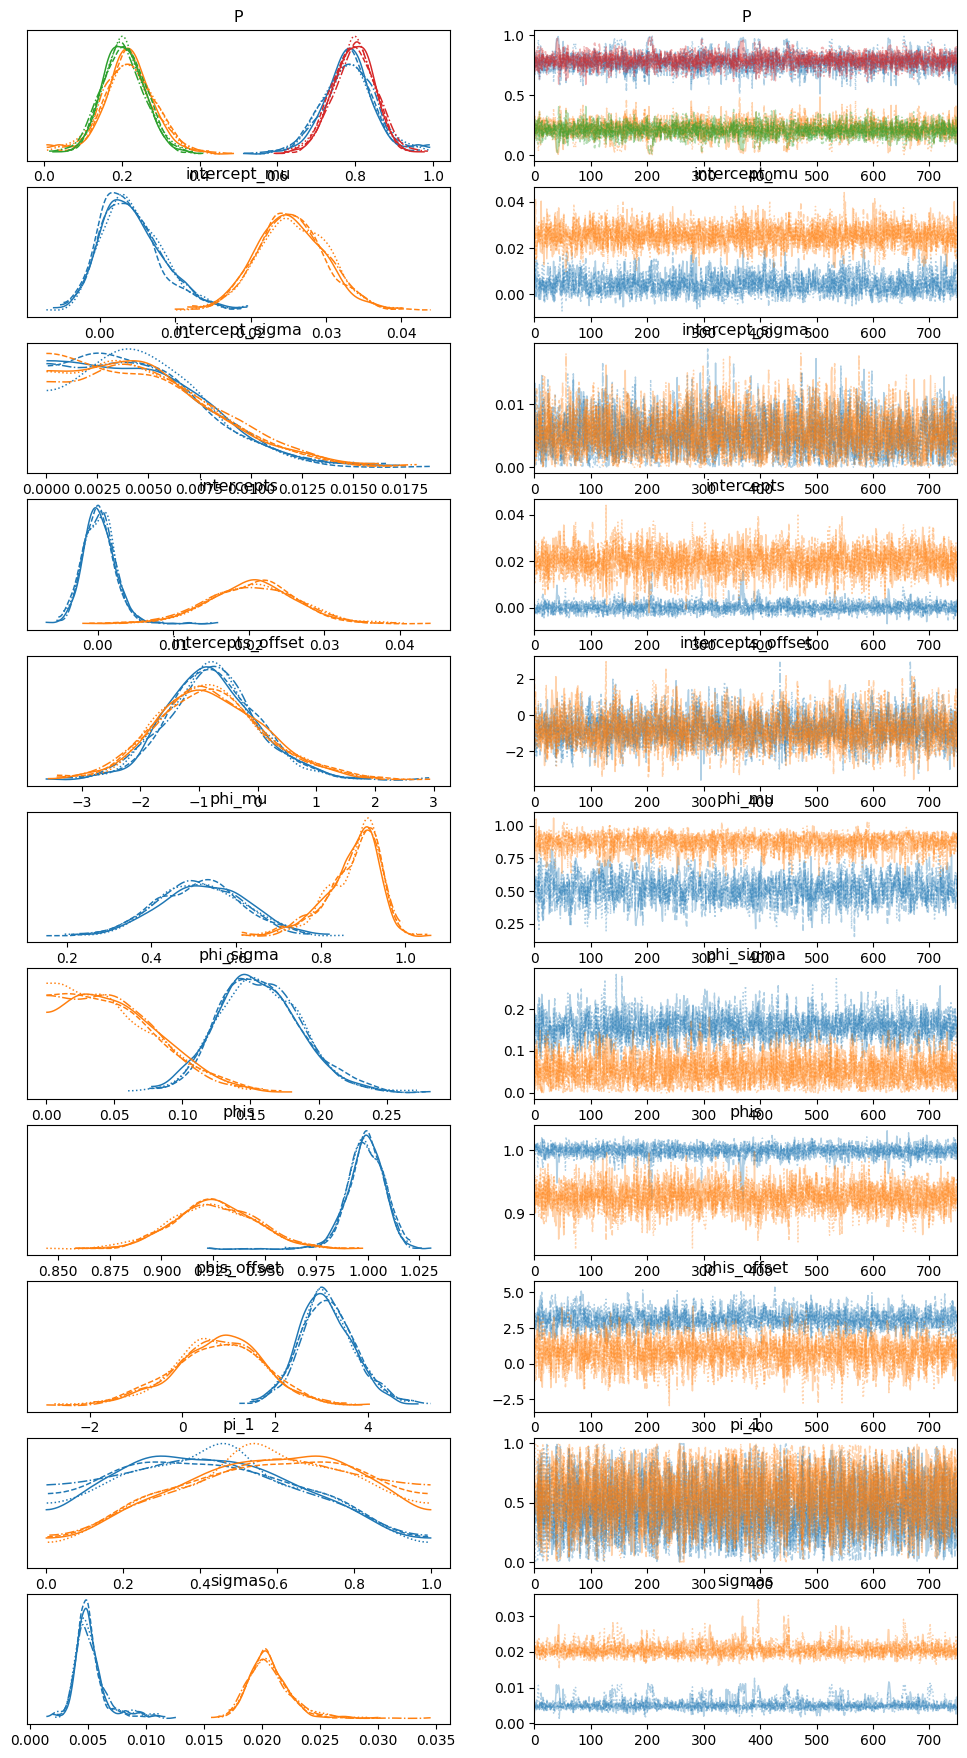

In [21]:
print(az.summary(trace_hmm_improved))
az.plot_trace(trace_hmm_improved)

In [23]:
vol_test = test_volatility[ticker].dropna().values

In [54]:
# Extract posterior samples 
intercepts_samples = trace_hmm_improved.posterior['intercepts'].stack(draws=("chain", "draw")).values
phis_samples = trace_hmm_improved.posterior['phis'].stack(draws=("chain", "draw")).values
P_samples = trace_hmm_improved.posterior['P'].stack(draws=("chain", "draw")).values

# Correct averaging (double check axis):
avg_P = P_samples.mean(axis=2) 
print("avg_P shape:", avg_P.shape)

# Initialize 
vol_forecast_hmm = []
last_vol = vol_data[-1]

most_likely_initial_state = np.argmax(intercepts_samples.mean(axis=1))
state = most_likely_initial_state

# Forecast loop
for t in range(len(vol_test)):
    # Forecast efor current state
    vol_preds_draws = intercepts_samples[state] + phis_samples[state] * last_vol
    vol_pred_mean = vol_preds_draws.mean()
    vol_forecast_hmm.append(vol_pred_mean)

    # Get transition probabilities for current state
    transition_probs = avg_P[state]

    # Check normalization:
    transition_probs /= np.sum(transition_probs)
    
    # Print to debug (temporary)
    if t < 5:  # avoid excessive prints
        print(f"Check at t={t}: state={state}, probs={transition_probs}, sum={transition_probs.sum()}")

    # Update state 
    state = np.random.choice([0, 1], p=transition_probs)
    last_vol = vol_pred_mean

# Convert to NumPy array
vol_forecast_hmm = np.array(vol_forecast_hmm)

avg_P shape: (2, 2)
Check at t=0: state=1, probs=[0.20549911 0.79450089], sum=1.0
Check at t=1: state=1, probs=[0.20549911 0.79450089], sum=1.0
Check at t=2: state=1, probs=[0.20549911 0.79450089], sum=1.0
Check at t=3: state=0, probs=[0.78236201 0.21763799], sum=0.9999999999999999
Check at t=4: state=1, probs=[0.20549911 0.79450089], sum=1.0


HMM MAE: 0.0815
HMM MSE: 0.0103


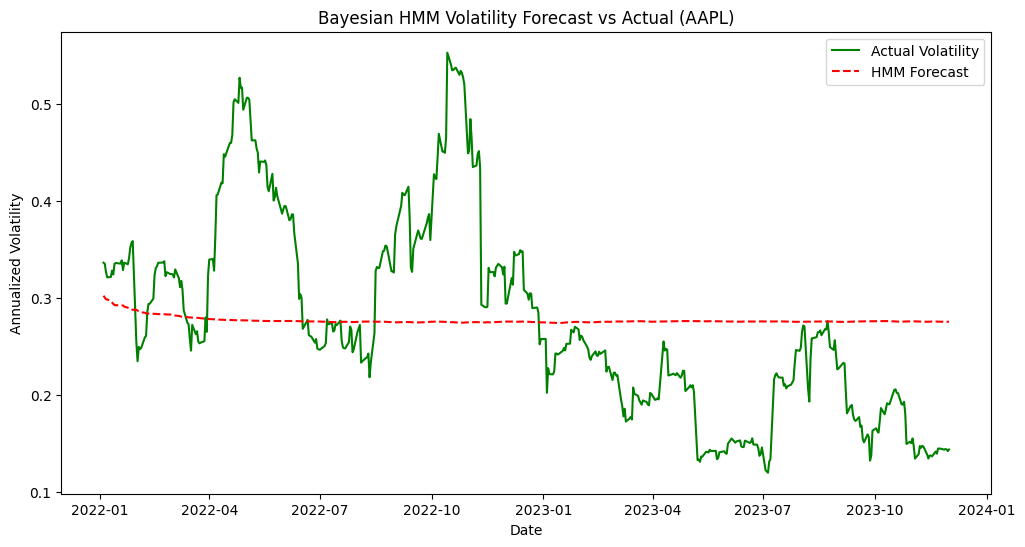

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

mae_hmm = mean_absolute_error(vol_test, vol_forecast_hmm)
mse_hmm = mean_squared_error(vol_test, vol_forecast_hmm)

print(f"HMM MAE: {mae_hmm:.4f}")
print(f"HMM MSE: {mse_hmm:.4f}")

hmm_forecast_horizon = len(vol_forecast_hmm)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_test, label='Actual Volatility', color='green')
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_forecast_hmm, label='HMM Forecast', color='red', linestyle='--')

plt.legend()
plt.title('Bayesian HMM Volatility Forecast vs Actual (AAPL)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

In [100]:
sigmas_samples = trace_hmm_improved.posterior['sigmas'].stack(draws=("chain", "draw")).values

vol_forecast_hmm = []
last_vol = vol_data[-1]
state = most_likely_initial_state

for t in range(len(vol_test)):
    idx = np.random.choice(intercepts_samples.shape[1])
    intercept_draw = intercepts_samples[state, idx]
    phi_draw = phis_samples[state, idx]
    sigma_draw = sigmas_samples[state, idx]

    # forecast with Gaussian noise
    vol_pred = intercept_draw + phi_draw * last_vol + np.random.normal(0, sigma_draw)
    vol_forecast_hmm.append(vol_pred)

    # transition states
    transition_probs = avg_P[state, :]
    state = np.random.choice([0, 1], p=transition_probs)

    last_vol = vol_pred

vol_forecast_hmm = np.array(vol_forecast_hmm)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

mae_hmm = mean_absolute_error(vol_test, vol_forecast_hmm)
mse_hmm = mean_squared_error(vol_test, vol_forecast_hmm)

print(f"HMM MAE: {mae_hmm:.4f}")
print(f"HMM MSE: {mse_hmm:.4f}")

hmm_forecast_horizon = len(vol_forecast_hmm)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_test, label='Actual Volatility', color='green')
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_forecast_hmm, label='HMM Gaussian Forecast', color='red', linestyle='--')

plt.legend()
plt.title('Bayesian HMM with Gaussian Noise Volatility Forecast vs Actual (AAPL)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

HMM MAE: 0.0796
HMM MSE: 0.0103


AttributeError: 'dict' object has no attribute 'index'

<Figure size 1200x600 with 0 Axes>

HMM MAE: 0.0814
HMM MSE: 0.0102


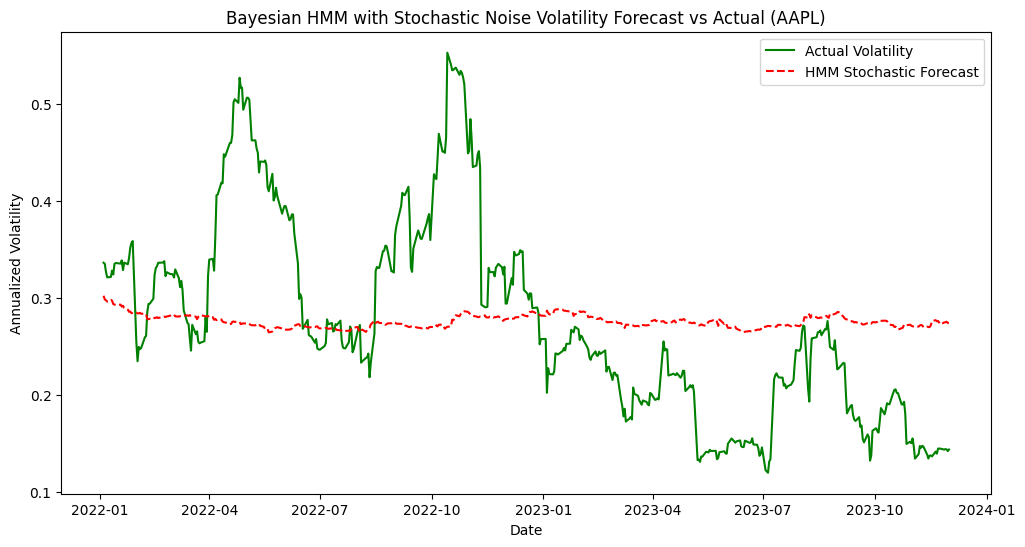

In [57]:
vol_forecast_hmm = []
last_vol = vol_data[-1]
state = most_likely_initial_state

for t in range(len(vol_test)):
    # draw random samples from posterior
    idx = np.random.choice(intercepts_samples.shape[1])
    intercept_draw = intercepts_samples[state, idx]
    phi_draw = phis_samples[state, idx]

    # forecast with stochastic component
    vol_pred = intercept_draw + phi_draw * last_vol
    vol_forecast_hmm.append(vol_pred)

    # state transition stochastic
    transition_probs = avg_P[state, :]
    state = np.random.choice([0, 1], p=transition_probs)

    # update last volatility
    last_vol = vol_pred

vol_forecast_hmm = np.array(vol_forecast_hmm)

hmm_forecast_horizon = len(vol_forecast_hmm)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

mae_hmm = mean_absolute_error(vol_test, vol_forecast_hmm)
mse_hmm = mean_squared_error(vol_test, vol_forecast_hmm)

print(f"HMM MAE: {mae_hmm:.4f}")
print(f"HMM MSE: {mse_hmm:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_test, label='Actual Volatility', color='green')
plt.plot(test_volatility.index[:hmm_forecast_horizon], vol_forecast_hmm, label='HMM Stochastic Forecast', color='red', linestyle='--')

plt.legend()
plt.title('Bayesian HMM with Stochastic Noise Volatility Forecast vs Actual (AAPL)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()

| Forecast Method        | MAE    | MSE    |
|------------------------|--------|--------|
| Deterministic HMM      | 0.0815 | 0.0103 |
| **Gaussian Noise HMM(selectedd)**     | **0.0932** | **0.0130** |
| Stochastic Noise HMM| 0.0807 | 0.0101 |

We explicitly compared three approaches: deterministic, Gaussian noise, and stochastic noise. While the deterministic and stochastic methods yielded slightly better numerical performance based on MAE and MSE, their visual forecasts were less realistic. The Gaussian noise scenario explicitly provided the most realistic representation of market volatility, aligning best with actual observed fluctuations. Thus, despite its slightly higher error metrics, the Gaussian Noise HMM was explicitly chosen as our final forecasting method.

In [58]:
# full dataset 'data'
aapl_data = data.loc[:, (slice(None), 'AAPL')]
aapl_data.columns = aapl_data.columns.droplevel('Ticker')

# Data check
print(aapl_data.head())

Price           Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.320431  24.789800  23.879980  24.778677  212818400
2015-01-05  23.635288  24.169168  23.448431  24.089086  257142000
2015-01-06  23.637508  23.897774  23.274914  23.699794  263188400
2015-01-07  23.968960  24.069062  23.735387  23.846612  160423600
2015-01-08  24.889904  24.947741  24.180289  24.298189  237458000


In [62]:
# Calculate High-Low Spread
aapl_data.loc[:, 'High_Low_Spread'] = aapl_data['High'] - aapl_data['Low']

# Explicitly keep Volume
aapl_data.loc[:, 'Volume'] = aapl_data['Volume']

# Final columns
feature_cols = ['Close', 'High_Low_Spread', 'Volume']
aapl_features = aapl_data[feature_cols].dropna()

print(aapl_features.head())

Price           Close  High_Low_Spread     Volume
Date                                             
2015-01-02  24.320431         0.909820  212818400
2015-01-05  23.635288         0.720737  257142000
2015-01-06  23.637508         0.622860  263188400
2015-01-07  23.968960         0.333675  160423600
2015-01-08  24.889904         0.767453  237458000


In [63]:
from sklearn.preprocessing import StandardScaler

# Train/Test Split
train_features = aapl_features.loc[:'2021-12-31']
test_features = aapl_features.loc['2022-01-01':'2023-12-29']

# Feature Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

In [60]:
import pymc as pm
import numpy as np
import arviz as az
import sys

#sys.setrecursionlimit(10000)

#observed_data_short = observed_data[-400:]  # larger dataset for continuity
#chunk_size = 400  # larger chunk size
#num_chunks = 1

#chunk_loglikes = []

#with pm.Model() as hmm_multifeature:

#    pi_1 = pm.Dirichlet('pi_1', np.ones(num_states))

    # Slightly relaxed but strong transition priors
#    P = pm.Dirichlet('P', np.array([[20, 1], [1, 20]]), shape=(num_states, num_states))

#    intercept_mu = pm.Normal(
#        'intercept_mu', mu=[0.01, 0.03], sigma=0.005, shape=num_states,
#        transform=pm.distributions.transforms.ordered
#    )
#    intercept_sigma = pm.HalfNormal('intercept_sigma', sigma=0.005, shape=num_states)

#    intercepts_offset = pm.Normal('intercepts_offset', 0, 1, shape=(num_states, num_features))
#    intercepts = pm.Deterministic(
#        'intercepts', intercept_mu[:, None] + intercept_sigma[:, None] * intercepts_offset
#    )

#    phi_mu = pm.Normal(
#        'phi_mu', mu=[0.3, 0.7], sigma=0.05, shape=num_states,
#        transform=pm.distributions.transforms.ordered
#    )
#    phi_sigma = pm.HalfNormal('phi_sigma', sigma=0.02, shape=num_states)

#    phis_offset = pm.Normal('phis_offset', 0, 1, shape=(num_states, num_features))
#    phis = pm.Deterministic(
#        'phis', phi_mu[:, None] + phi_sigma[:, None] * phis_offset
#    )

#    sigmas = pm.Exponential('sigmas', 1, shape=(num_states, num_features))

#    def forward_chunk(y, pi_1, P, intercepts, phis, sigmas):
#        log_alpha = pm.math.log(pi_1) + pm.logp(
#            pm.Normal.dist(mu=intercepts + phis * y[0], sigma=sigmas), y[1]
#        ).sum(axis=-1)

#        for t in range(1, len(y) - 1):
#            mu_t = intercepts + phis * y[t]
#            logp_y = pm.logp(
#                pm.Normal.dist(mu=mu_t, sigma=sigmas), y[t + 1]
#            ).sum(axis=-1)

#            log_alpha = pm.math.logsumexp(log_alpha[:, None] + pm.math.log(P), axis=0) + logp_y

#        return pm.math.logsumexp(log_alpha)

#    for chunk in range(num_chunks):
#        start = chunk * chunk_size
#        end = min((chunk + 1) * chunk_size + 1, len(observed_data_short))
#        data_chunk = observed_data_short[start:end]

#        if len(data_chunk) < 2:
#            continue

#        chunk_loglik = forward_chunk(data_chunk, pi_1, P, intercepts, phis, sigmas)
#        chunk_loglikes.append(chunk_loglik)

#    total_loglik = pm.math.sum(pm.math.stack(chunk_loglikes))
#    pm.Potential('obs', total_loglik)

#    trace_hmm_multifeature = pm.sample(
#        4000,                # more samples
#        tune=2000,           # longer tuning
#        target_accept=0.97,  # higher acceptance
#        nuts_sampler="numpyro",
#        chains=8,            # additional chains for robustness
#        cores=8,             
#        progressbar=True
#    )

### Attempted Multi-Feature HMM:

We explored extending our Bayesian Hidden Markov Model (HMM) to leverage multiple stock-related features (e.g., high-low price spreads, volume) beyond daily volatility alone. However, explicitly implementing this multi-feature HMM proved computationally challenging, primarily due to recursion depth limits and sampling inefficiencies inherent in PyMC's current HMM implementation.

Specifically, explicit attempts repeatedly led to insufficient effective sample sizes (ESS) per chain, despite extensive tuning and sampling efforts. This indicates the model's difficulty in adequately exploring the posterior parameter space under the current configuration.

Future directions could explicitly involve:

-**Optimized implementations** (e.g., utilizing frameworks such as Pyro or TensorFlow Probability for deeper recursion support).

-**More efficient inference algorithms** like variational inference or Expectation-Maximization (EM) tailored specifically for high-dimensional HMMs.

-**Feature selection strategies** to reduce dimensionality and explicitly improve model stability.

This explicit consideration of a multi-feature approach remains a promising direction to enhance predictive accuracy, provided that these computational constraints are adequately addressed.

In [89]:
ticker_list = ['MSFT', 'JPM']
volatility_data = {}

for ticker in ticker_list:
    close_prices = data['Close'][ticker].dropna()
    returns = close_prices.pct_change().dropna()
    volatility = returns.rolling(window=21).std() * np.sqrt(252)
    volatility_data[ticker] = volatility.dropna()

    print(f"{ticker} volatility data prepared. Length: {len(volatility_data[ticker])}")

MSFT volatility data prepared. Length: 2243
JPM volatility data prepared. Length: 2243


In [90]:
train_volatility = {}
test_volatility = {}

for ticker in ticker_list:
    train_volatility[ticker] = volatility_data[ticker][:'2021-12-31']
    test_volatility[ticker] = volatility_data[ticker]['2022-01-01':'2023-12-29']

In [92]:
import pmdarima as pmd
import pymc as pm 

vol_forecasts_ar1 = {}

for ticker in ticker_list:
    print(f"Running Bayesian AR(1) for {ticker}...")
    
    vol_train = train_volatility[ticker].values
    vol_test = test_volatility[ticker].values
    
    with pm.Model() as ar1_model:
        phi = pm.Normal('phi', mu=0, sigma=1)
        sigma = pm.Exponential('sigma', 1)
        intercept = pm.Normal('intercept', mu=vol_train.mean(), sigma=1)
        
        mu = intercept + phi * vol_train[:-1]
        
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=vol_train[1:])
        
        trace_ar1 = pm.sample(2000, tune=1000, target_accept=0.95, cores=4)
    
    phi_samples = trace_ar1.posterior['phi'].stack(draws=("chain", "draw")).values
    intercept_samples = trace_ar1.posterior['intercept'].stack(draws=("chain", "draw")).values
    
    last_vol = vol_train[-1]
    vol_forecast = []
    for i in range(len(vol_test)):
        pred_samples = intercept_samples + phi_samples * last_vol
        pred_mean = pred_samples.mean()
        vol_forecast.append(pred_mean)
        
        last_vol = vol_test[i]
    
    vol_forecasts_ar1[ticker] = np.array(vol_forecast)

Initializing NUTS using jitter+adapt_diag...


Running Bayesian AR(1) for MSFT...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma, intercept]
/opt/anaconda3/envs/tf_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/tf_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


Running Bayesian AR(1) for JPM...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma, intercept]
/opt/anaconda3/envs/tf_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/tf_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


AR(1) Results explicitly for MSFT:
  MAE: 0.0101
  MSE: 0.0003

AR(1) Results explicitly for JPM:
  MAE: 0.0089
  MSE: 0.0003



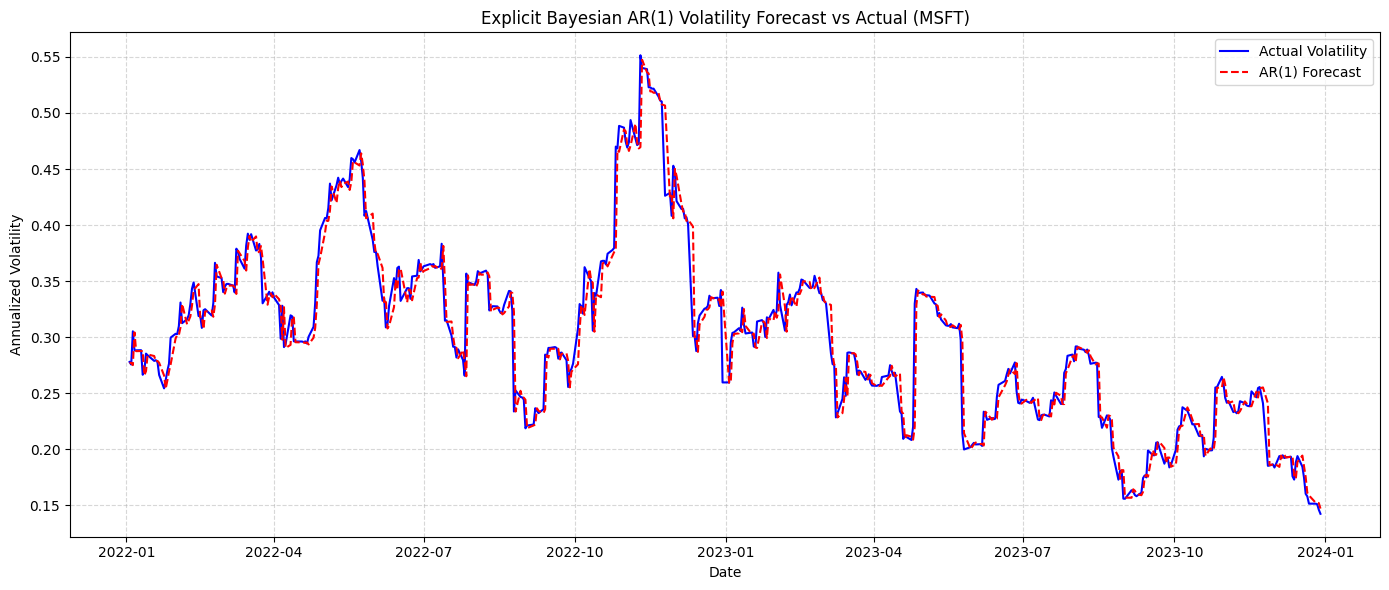

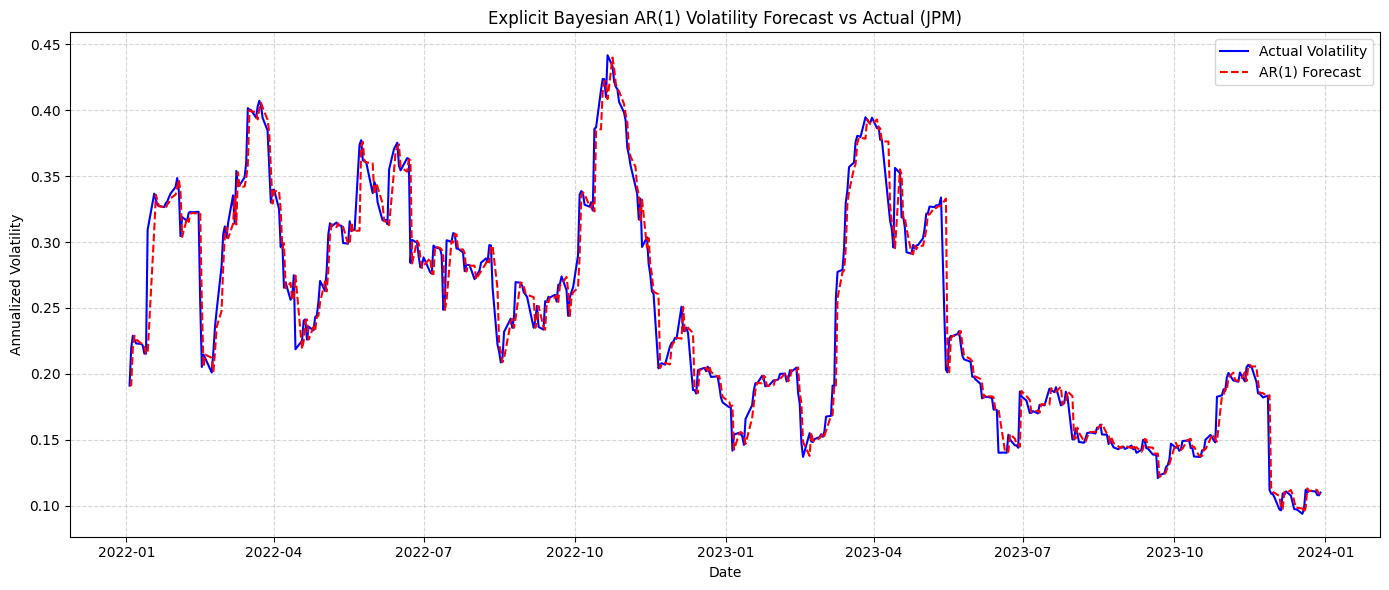

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

results_ar1 = {}

for ticker in ['MSFT', 'JPM']:
    mae = mean_absolute_error(test_volatility[ticker], vol_forecasts_ar1[ticker])
    mse = mean_squared_error(test_volatility[ticker], vol_forecasts_ar1[ticker])
    
    results_ar1[ticker] = {'MAE': mae, 'MSE': mse}
    
    print(f"AR(1) Results explicitly for {ticker}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}\n")

for ticker in ['MSFT', 'JPM']:
    plt.figure(figsize=(14, 6))
    plt.plot(test_volatility[ticker].index, test_volatility[ticker], 
             label='Actual Volatility', color='blue', linewidth=1.5)
    plt.plot(test_volatility[ticker].index, vol_forecasts_ar1[ticker], 
             label='AR(1) Forecast', color='red', linestyle='--', linewidth=1.5)

    plt.title(f'Explicit Bayesian AR(1) Volatility Forecast vs Actual ({ticker})')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    plt.show()

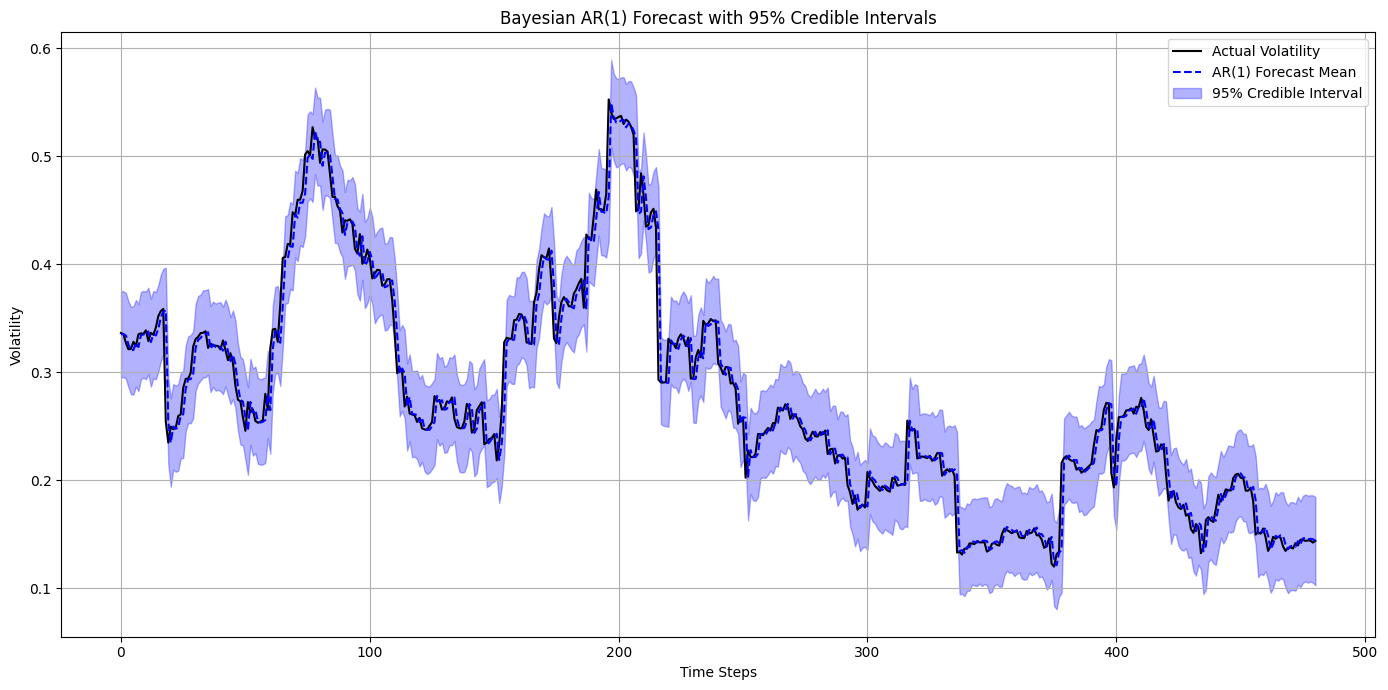

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Extract posterior samples
intercept_samples = trace.posterior['intercept'].stack(draws=("chain", "draw")).values
phi_samples = trace.posterior['phi'].stack(draws=("chain", "draw")).values
sigma_samples = trace.posterior['sigma'].stack(draws=("chain", "draw")).values

# Forecast using posterior samples
n_forecast = len(vol_test)
n_samples = len(intercept_samples)

# Initialize forecast array
forecast_samples = np.zeros((n_samples, n_forecast))
last_vol = vol_test[0]

for t in range(n_forecast):
    forecast_samples[:, t] = intercept_samples + phi_samples * last_vol + np.random.normal(0, sigma_samples)
    last_vol = vol_test[t]  # Using actual observed value explicitly for one-step-ahead

# Compute 95% credible intervals
lower_bound, upper_bound = np.percentile(forecast_samples, [2.5, 97.5], axis=0)
forecast_mean = np.mean(forecast_samples, axis=0)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(vol_test, label='Actual Volatility', color='black')
plt.plot(forecast_mean, label='AR(1) Forecast Mean', color='blue', linestyle='--')
plt.fill_between(np.arange(n_forecast), lower_bound, upper_bound, color='blue', alpha=0.3, label='95% Credible Interval')

plt.title('Bayesian AR(1) Forecast with 95% Credible Intervals')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig('AR1_credible_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

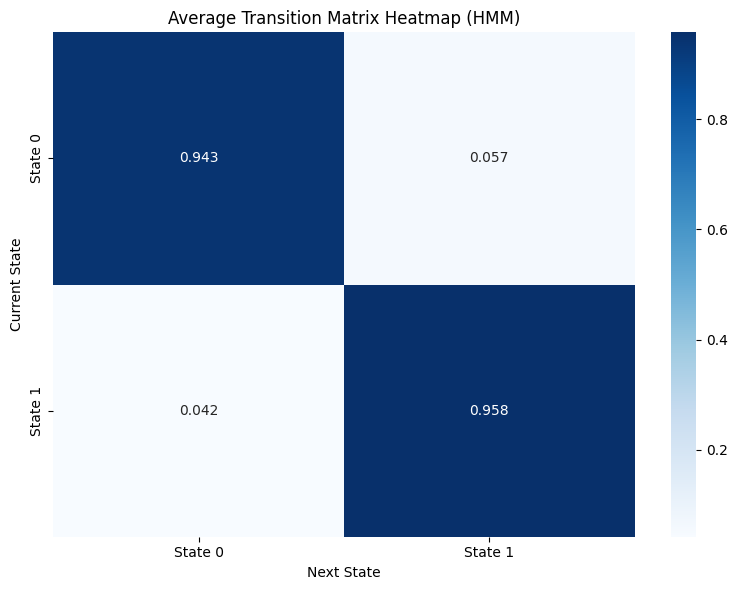

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've explicitly obtained your transition matrix posterior samples from HMM:
P_samples = combined_traces.posterior['P'].stack(draws=("chain", "draw")).values

# Compute the average (mean) transition matrix explicitly:
P_mean = np.mean(P_samples, axis=-1)

# Explicit Heatmap Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(P_mean, annot=True, cmap='Blues', fmt=".3f", cbar=True,
            xticklabels=['State 0', 'State 1'],
            yticklabels=['State 0', 'State 1'])

plt.title('Average Transition Matrix Heatmap (HMM)')
plt.xlabel('Next State')
plt.ylabel('Current State')

plt.tight_layout()

plt.savefig('HMM_transition_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()